# 事前準備

In [263]:
import os
import json

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from modules.file_format.read_spe import TimeStamp


In [264]:
# 自作モジュールの読み込み
from modules.file_format.HDF5 import HDF5Reader


In [265]:
"""pathの設定"""
import sys
repository_root = None
for sys_path in sys.path:
    if sys_path.endswith('LAMBDA-Melting'):
        repository_root = sys_path
if repository_root is None:
    raise ValueError('repository_root is not set')

"""plot用の設定"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'     #数式用のフォントejavuserif" or "cm"
plt.rcParams['xtick.direction'] = 'in'      #x軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'      #y軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0     #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0     #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 14               #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.8        #軸の線幅edge linewidth。囲みの太さ
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
# Arialフォントを設定
plt.rcParams.update({
    "font.family": "Arial",           # フォントをArialに設定
    "mathtext.fontset": "custom",     # カスタムフォントを指定
    "mathtext.rm": "Arial",           # 数式の通常テキスト部分
    "mathtext.it": "Arial",    # 数式のイタリック部分
    "mathtext.bf": "Arial"       # 数式の太字部分
})


# 使用するRunのリストを作成

In [266]:
# hdfまでのroot
path_to_run_setting = os.path.join(repository_root, 'settings', 'run_selector.json')
with open(path_to_run_setting) as json_file:
    selected_run_setting = json.load(json_file)

hdf_folder = os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
)
hdf_folder


'/Users/ishizawaosamu/work/MasterThesis/save/processed_hdf'

In [267]:
files = sorted(os.listdir(hdf_folder))
files


['.DS_Store',
 'OIbDia08_1st_down_processed.hdf',
 'OIbDia08_1st_up_processed.hdf',
 'OIbDia08_2nd_down_processed.hdf',
 'OIbDia08_2nd_up_processed.hdf',
 'OIbDia08_3rd_down_processed.hdf',
 'OIbDia08_3rd_up_processed.hdf',
 'OIbDia08_4th_down_processed.hdf',
 'OIbDia08_4th_up_processed.hdf',
 'OIbDia08_5th_down_processed.hdf',
 'OIbDia08_5th_up_processed.hdf',
 'OIbDia08_6th_down_processed.hdf',
 'OIbDia08_6th_up_processed.hdf',
 'OIbDia08_7th_down_processed.hdf',
 'OIbDia08_7th_up_processed.hdf']

In [268]:
# リストを作成
melted_list = [
    'OIbDia08_2nd_down',
]

In [269]:
# hdf化

In [270]:
melt_dict = {}

for file in files:
    for melted in melted_list:
        if (melted in file) and (not file.startswith('.')):
            if melted not in melt_dict:  # 必要なときだけ初期化
                melt_dict[melted] = {}
            melt_dict[melted]['hdf'] = HDF5Reader(os.path.join(hdf_folder, file))
melt_dict[melted_list[0]]

HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_down_processed.hdf


{'hdf': <modules.file_format.HDF5.HDF5Reader at 0x12a5650d0>}

In [271]:
melt_dict[melted_list[0]]['hdf'].path_list

['entry/error/dia111/fitted_V_max',
 'entry/error/dia111/fitted_V_min',
 'entry/error/kcl110/fitted_V_max',
 'entry/error/kcl110/fitted_V_min',
 'entry/measured/dia111/fitted_V',
 'entry/measured/dia111/max_pos_V',
 'entry/measured/error/T',
 'entry/measured/error/fitted_V_max/dia111',
 'entry/measured/error/fitted_V_max/kcl110',
 'entry/measured/error/fitted_V_min/dia111',
 'entry/measured/error/fitted_V_min/kcl110',
 'entry/measured/kcl110/fitted_V',
 'entry/measured/kcl110/max_pos_V',
 'entry/measured/value/T',
 'entry/measured/value/fitted_V/dia111',
 'entry/measured/value/fitted_V/kcl110',
 'entry/measured/value/frame_T',
 'entry/measured/value/frame_XRD',
 'entry/measured/value/max_pos_V/dia111',
 'entry/measured/value/max_pos_V/kcl110',
 'entry/measured/value/max_position_T',
 'entry/measured/value/pattern',
 'entry/measured/value/tth',
 'entry/params/frame/T',
 'entry/params/frame/XRD',
 'entry/params/framerate/T',
 'entry/params/framerate/XRD',
 'entry/params/x-ray_wavelength'

# 自分の融点を取得

In [272]:
# breakpoints_xから指数を得るメソッド
# 配列と値を渡したら、値に最も近いindexを返す関数
def return_idx(arr, *values):
    idxs = tuple(int((np.abs(arr - value)).argmin()) for value in values)
    # valuesが1つであればタプルではなく単独の値を返す
    return idxs[0] if len(idxs) == 1 else idxs

# y軸の値が近い方を返してもらう関数
def return_closest_idx(arr_x, arr_y, breakpoints_x, breakpoints_y):
    """
    arr_x: 全てのx値の配列
    arr_y: 全てのy値の配列
    breakpoints_x: 求めたいbreakpointのx値
    breakpoints_y: 求めたいbreakpointのy値

    return: 各breakpointに対応するインデックス
    """
    # 入力確認
    if not isinstance(breakpoints_x, (list, np.ndarray)):
        breakpoints_x = [breakpoints_x]
    if not isinstance(breakpoints_y, (list, np.ndarray)):
        breakpoints_y = [breakpoints_y]
    idxs = []

    for bp_x, bp_y in zip(breakpoints_x, breakpoints_y):
        # x軸に最も近い点のインデックスを取得
        closest_idx = int((np.abs(arr_x - bp_x)).argmin())

        # 最も近いインデックスの前後を確認
        candidate_idxs = []
        if closest_idx > 0:
            candidate_idxs.append(closest_idx - 1)
        candidate_idxs.append(closest_idx)
        if closest_idx < len(arr_x) - 1:
            candidate_idxs.append(closest_idx + 1)

        # y軸の距離で評価
        candidate_idxs = np.array(candidate_idxs)
        distances = np.abs(arr_y[candidate_idxs] - bp_y)
        best_idx = candidate_idxs[np.argmin(distances)]

        idxs.append(best_idx)

    return idxs


In [273]:
segments_num = 4
melting_segment = 2

for run_name in melt_dict.keys():
    breakpoints_x = melt_dict[run_name]['hdf'].find_by(query=f'segment_{segments_num}/breakpoints_x')
    breakpoints_y = melt_dict[run_name]['hdf'].find_by(query=f'segment_{segments_num}/breakpoints_y')

    time_array = melt_dict[run_name]['hdf'].find_by(query='frame_XRD') / melt_dict[run_name]['hdf'].find_by(query='framerate/XRD')
    T_array = melt_dict[run_name]['hdf'].find_by(query='value/interpolated_T')
    T_error_array = melt_dict[run_name]['hdf'].find_by(query='error/interpolated_T')
    P_array = melt_dict[run_name]['hdf'].find_by(query='value/P')
    P_error_array = melt_dict[run_name]['hdf'].find_by(query='error/P')

    # indexを取得
    breakpoint_x_idx = return_closest_idx(
        time_array,
        T_array,
        breakpoints_x[melting_segment],
        breakpoints_y[melting_segment]
    )

    # 代入
    melt_dict[run_name]['original_time'] = breakpoints_x[melting_segment]
    melt_dict[run_name]['time'] = time_array[breakpoint_x_idx]
    melt_dict[run_name]['T'] = T_array[breakpoint_x_idx]
    melt_dict[run_name]['T_error'] = T_error_array[breakpoint_x_idx]
    melt_dict[run_name]['P'] = P_array[melting_segment]
    melt_dict[run_name]['P_error'] = P_error_array[melting_segment]

「segment_4/breakpoints_x」で検索します。
	-> entry/pwlf_fitting/segment_4/breakpoints_x を返しました。
「segment_4/breakpoints_y」で検索します。
	-> entry/pwlf_fitting/segment_4/breakpoints_y を返しました。
「frame_XRD」で検索します。
	-> entry/measured/value/frame_XRD を返しました。
「framerate/XRD」で検索します。
	-> entry/params/framerate/XRD を返しました。
「value/interpolated_T」で検索します。
	-> entry/processed/value/interpolated_T を返しました。
「error/interpolated_T」で検索します。
	-> entry/processed/error/interpolated_T を返しました。
「value/P」で検索します。
	-> entry/processed/value/P を返しました。
「error/P」で検索します。
	-> entry/processed/error/P を返しました。


In [274]:
melt_dict

{'OIbDia08_2nd_down': {'hdf': <modules.file_format.HDF5.HDF5Reader at 0x12a5650d0>,
  'original_time': np.float64(9.44514943492746),
  'time': array([9.45]),
  'T': array([5453.37476041]),
  'T_error': array([222.44212718]),
  'P': np.float64(26.22454762159227),
  'P_error': np.float64(0.16799999999999998)}}

## plot設定

In [275]:
result_option = {
    'fmt': "o",
    'capsize': 3,
    'elinewidth': 1.5,
    'capthick': 1.5,
    'markersize': 10,
    'markeredgewidth': 1.5,
    'color': 'red',
    'mfc': 'white'
}


def plot_results(ax: plt.Axes):
    for i, run_name in enumerate(melt_dict.keys()):
        T = melt_dict[run_name]['T']
        T_error = melt_dict[run_name]['T_error']
        P = melt_dict[run_name]['P']
        P_error = melt_dict[run_name]['P_error']
        ax.errorbar(x=P, y=T, xerr=P_error, yerr=T_error,
                    label='Melt occurrence (this study)' if i == 0 else None, **result_option)

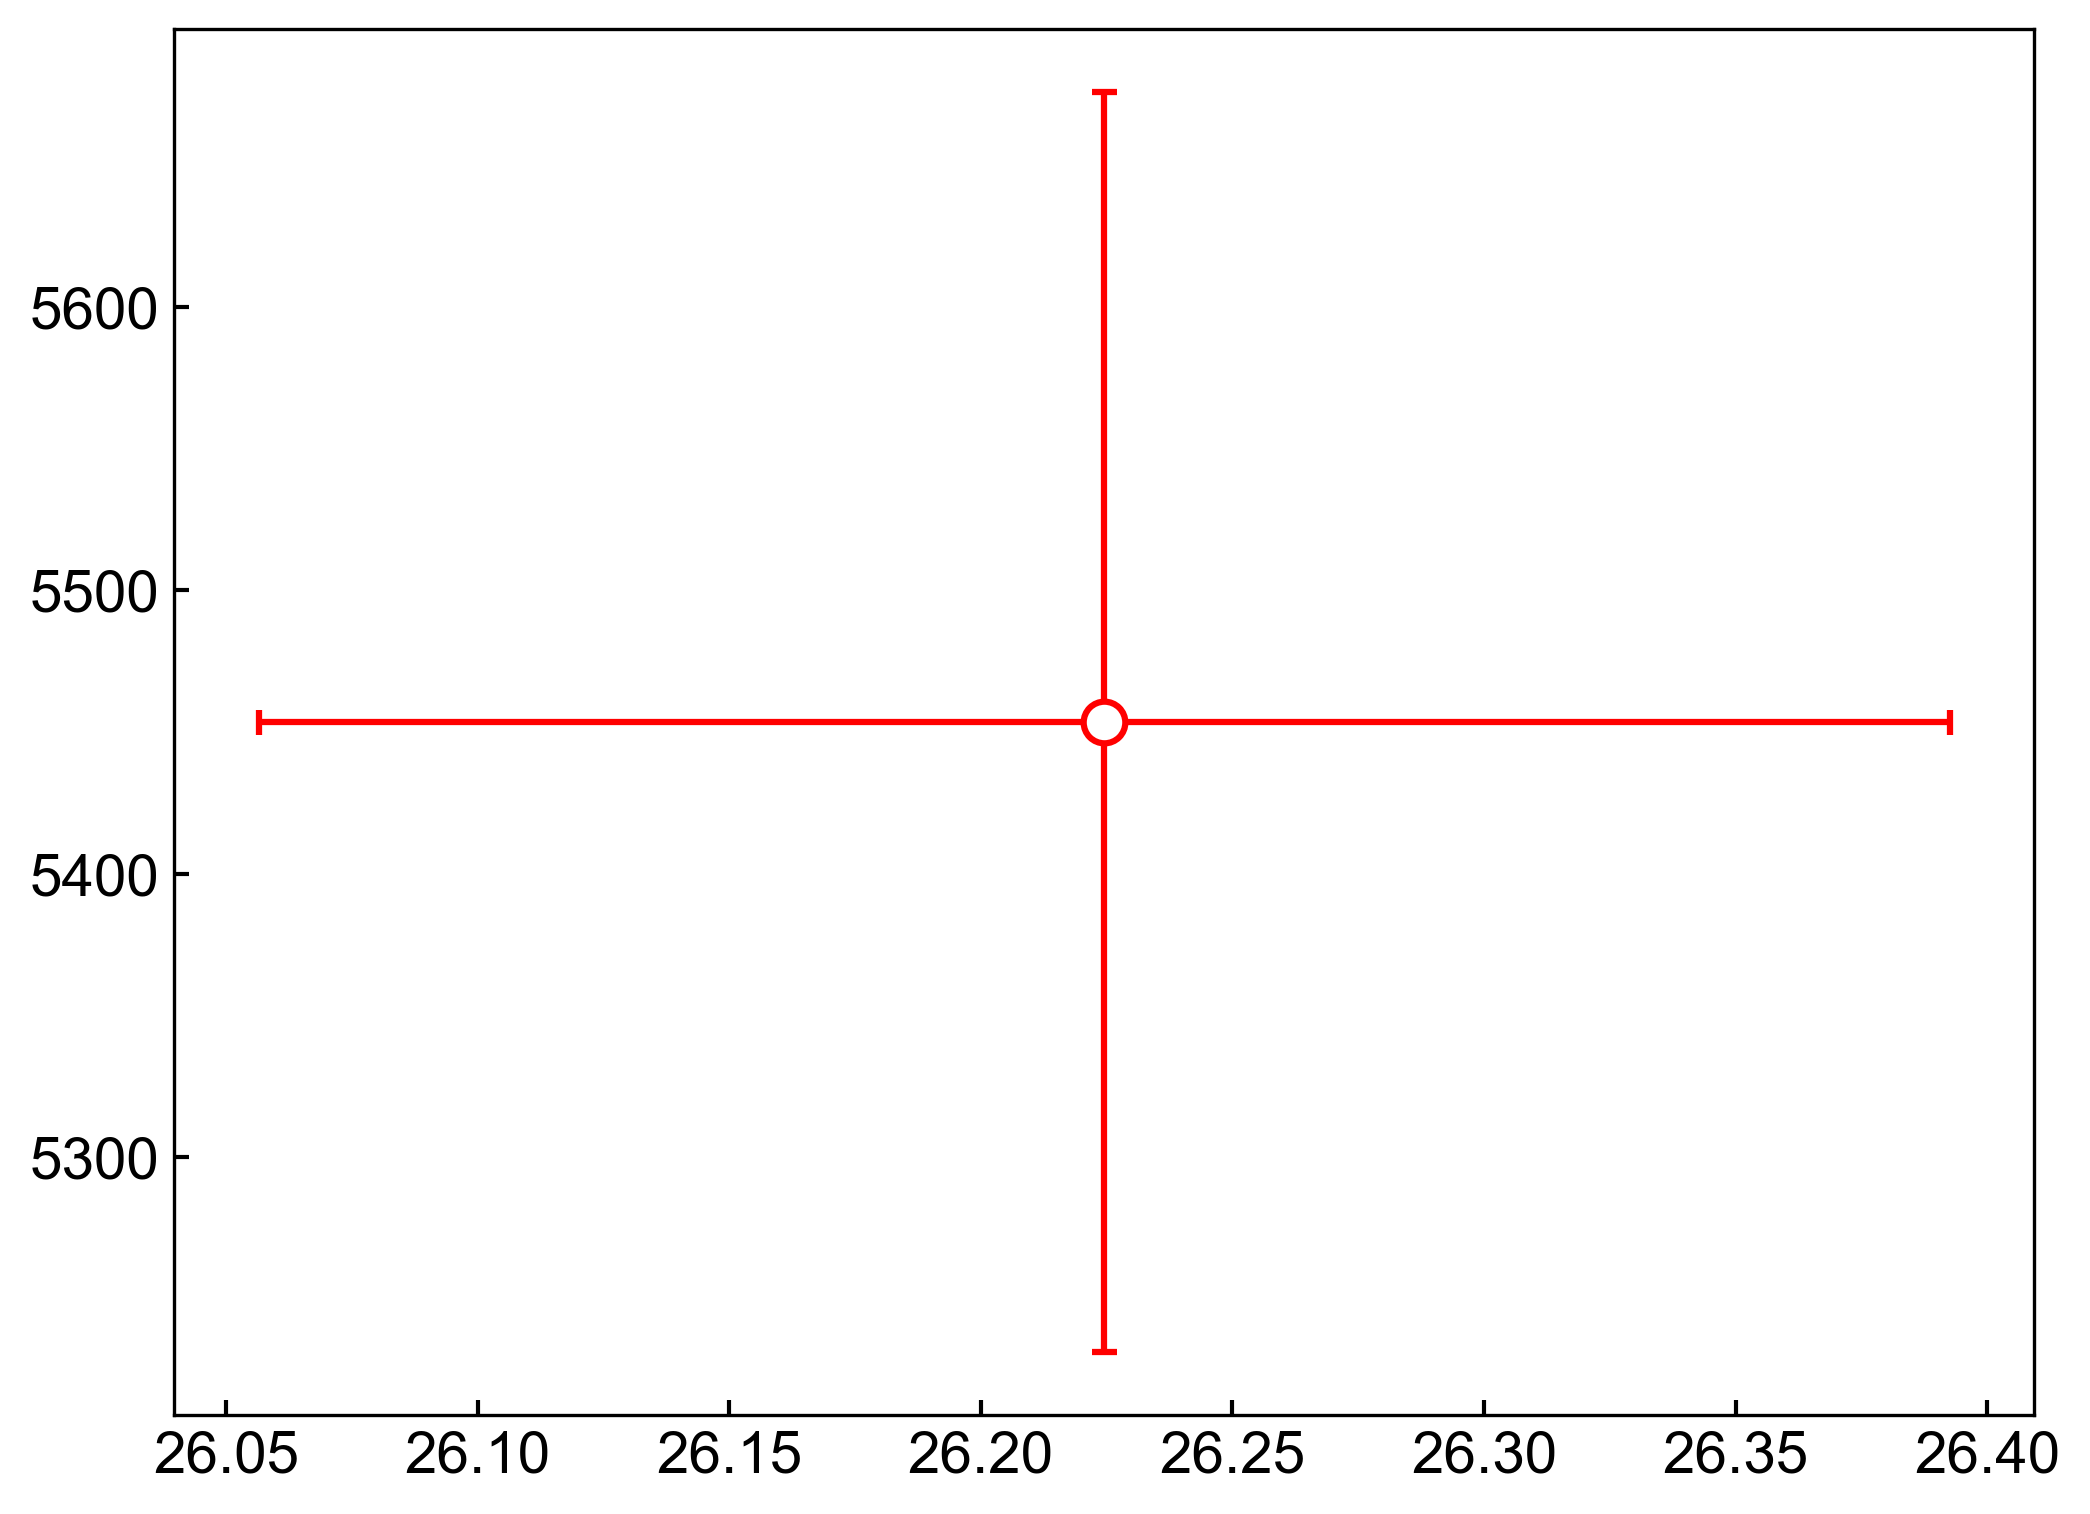

In [276]:
fig, ax = plt.subplots()
plot_results(ax=ax)

# データの取得

In [277]:
path_to_early = os.path.join(repository_root, 'early_studies')

path_to_bdd_heater = os.path.join(path_to_early, 'condition', 'BDD_heater')
path_to_diamond_formation = os.path.join(path_to_early, 'condition', 'diamond_formation')

path_to_geotherm = os.path.join(path_to_early, 'geotherm')

path_to_melting = os.path.join(path_to_early, 'melting_points')
path_to_diamond_melting = os.path.join(path_to_melting, 'diamond')
path_to_graphite_melting = os.path.join(path_to_melting, 'graphite')

path_to_phase = os.path.join(path_to_early, 'phase', 'diamond')

In [278]:
# csvを読み込んだときに、dataframeにつける軸のラベル
# 基本的に圧力列 / 温度列
names = ['P', 'T']
opposite_names = ['T', 'P']

## Grahpite / Bundy, Day, Sav...

In [279]:
# Bundy
path_to_bundy = os.path.join(path_to_phase, "bundy1996_TP")

bundy_GDL = pd.read_csv(os.path.join(path_to_bundy, "GDL_point.csv"), header=None, names=opposite_names)
bundy_GL = pd.read_csv(os.path.join(path_to_bundy, "GL_boundary.csv"), header=None, names=opposite_names)
bundy_GD = pd.read_csv(os.path.join(path_to_bundy, "GD_boundary.csv"), header=None, names=opposite_names)
bundy_DL = pd.read_csv(os.path.join(path_to_bundy, "DL_boundary.csv"), header=None, names=opposite_names)
bundy_DL['T'] += 50

bundy_boundaries = [
    bundy_GD,
    # bundy_DL,
    bundy_GL
]

bundy_GDL_option = {
    'color': 'black',
    'facecolor': 'white',
    'linewidth': 2,
    's': 150,
    'zorder': 10
}

bundy_GDL_data = [
    (bundy_GDL['P'], bundy_GDL['T'], 'GDL (Bundy 1996)', bundy_GDL_option),
]

bundy_boundaries_option = {
    'color': 'black',
    'linewidth': 2
}

# Bundyの線をプロット
def plot_bundy_lines(ax, with_DL=False, boundaries=bundy_boundaries, boundary_option=bundy_boundaries_option):
    lines = boundaries.copy()
    if with_DL:
        lines.append(bundy_DL)
    for i, boundary in enumerate(lines):
        label = "Bundy 1996" if i == 0 else None  # 最初だけラベルを追加
        ax.plot(boundary['P'], boundary['T'], label=label, **boundary_option)

def plot_GDL(ax, data=bundy_GDL_data):
    for P, T, label, style in data:
        style = {k: v for k, v in style.items() if k != 'label'}  # 'label' を除去
        ax.scatter(P, T, label=label, **style)


In [280]:
# Day
day_GD = pd.read_csv(os.path.join(path_to_phase, "day2012_GD.csv"), header=None, names=['T', 'dammy1', 'P', 'dammy2', 'dammy3'])
day_GD['P'] /= 10 # kbarから変換

def plot_day(ax: plt.Axes):
    ax.scatter(day_GD['P'], day_GD['T'], label='Day 2012', color='black', marker='d', s=50, fc='white')

# 外挿曲線も作っておく
def quadratic_model(T, a, b, c):
    return a + b * T + c * T**2

P_fit_params_day, _ = curve_fit(quadratic_model, day_GD['T'], day_GD['P'])
T_fit_day = np.linspace(298, 4100, 500)
P_fit_day = quadratic_model(T_fit_day, *P_fit_params_day)

def plot_day_fit(ax: plt.Axes):
    ax.plot(P_fit_day, T_fit_day, color='red', linestyle='--', linewidth=2, label='Day 2012 fit')

In [281]:
# graphite review (sav...)
path_to_graphite_melting = os.path.join(path_to_melting, "graphite")

graphite_meltings = pd.read_csv(os.path.join(path_to_graphite_melting, "Savvatimskiy_review_2005.csv"))

# togayaだけ抽出しておく
togaya1997 = graphite_meltings[graphite_meltings['author'] == 'Togaya']
T_fit_params_togaya, _ = curve_fit(quadratic_model, togaya1997['P'], togaya1997['T'])
P_fit_togaya = np.linspace(0, 14, 500)
T_fit_togaya = quadratic_model(P_fit_togaya, *T_fit_params_togaya)
def plot_togaya_fit(ax: plt.Axes):
    ax.plot(P_fit_togaya, T_fit_togaya, color='red', linestyle=':', linewidth=2, label='Togaya 1997 fit')

# グラファイト融点
graphite_option = {
    'scatter': {
        'color': 'red',
        's': 60,
        'marker': 'h',
        'facecolor': 'white',
        'linewidths': 1,
    },
    'errorbar': {
        'color': 'red',
        'fmt': "h",
        'capsize': 5,
        'elinewidth': 1,
        'capthick': 1,
        'markersize': 8,
        'markeredgewidth': 1,
        'mfc': 'white',
    }
}

def plot_graphite_melting(ax, graphite_meltings=graphite_meltings, graphite_option=graphite_option):
    for i in graphite_meltings.index:
        row = graphite_meltings.iloc[i]
        P, T = row['P'], row['T']
        P_error, T_error = row['P_error'], row['T_error']
        if P_error == 0 and T_error == 0:
            if i == 0:
                ax.scatter(P, T, label='Gra. melt (Savvatimskiy 2005)', **graphite_option['scatter'])
            else:
                ax.scatter(P, T, **graphite_option['scatter'])
        elif P_error == 0:
            ax.errorbar(P, T, yerr=T_error, **graphite_option['errorbar'])
        elif T_error == 0:
            ax.errorbar(P, T, xerr=P_error, **graphite_option['errorbar'])
        else:
            ax.errorbar(P, T, xerr=P_error, yerr=T_error, **graphite_option['errorbar'])



/var/folders/lf/1z5g9_557nzf78kbnnnvx7m80000gn/T/ipykernel_77297/244189972.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  T_fit_params_togaya, _ = curve_fit(quadratic_model, togaya1997['P'], togaya1997['T'])


## Diamond / WB, Yang, Shaner, Eggert,

In [282]:
# Weathers & Bassets
WB_area = {
    'P': [15, 15, 30, 30],
    'T': [5_000, 6_000, 6_000, 5_000],
}

def plot_WB_area(ax):
    ax.fill(WB_area['P'], WB_area['T'], color='red', alpha=0.2, label='Weathers & Basset 1987')

In [283]:
# Yang 2022 <- 2023だった
## Solid
yang_solid_grapite = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "solid_graphite.csv"), header=None, names=names)
yang_solid_glassy = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "solid_glassy.csv"), header=None, names=names)
yang_solid_furnace = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "solid_furnace.csv"), header=None, names=names)
yang_solid_disk = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "solid_Redisk.csv"), header=None, names=names)
yang_solids = [
    yang_solid_grapite,
    yang_solid_glassy,
    yang_solid_furnace,
    yang_solid_disk
]

## Melt
yang_melt_grapite = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "melt_graphite.csv"), header=None, names=names)
yang_melt_glassy = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "melt_glassy.csv"), header=None, names=names)
yang_melt_furnace = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "melt_furnace.csv"), header=None, names=names)
yang_melt_disk = pd.read_csv(os.path.join(path_to_diamond_melting, "yang2022", "melt_Redisk.csv"), header=None, names=names)
yang_melts = [
    yang_melt_grapite,
    yang_melt_glassy,
    yang_melt_furnace,
    yang_melt_disk
]

marker_size = 60

phase_marker_size = marker_size

yang_markers = [
    '^',
    'o',
    'D',
    's'
]
yang_melt_option = {
    's': phase_marker_size - 20,
    'color': 'darkorange',
    'fc': 'white',
    'linewidth': 1,
    'zorder': 20
}
yang_solid_option = {
    's': phase_marker_size - 20,
    'color': 'blue',
    'fc': 'white',
    'linewidth': 1,
    'zorder': 20
}


def plot_yang(ax, melts=yang_melts, solids=yang_solids, markers=yang_markers, melt_option=yang_melt_option, solid_option=yang_solid_option):
    # Meltsのプロット
    for i, yang in enumerate(melts):
        label = "Yang 2023 melts" if i == 0 else None
        ax.scatter(yang['P'], yang['T'], marker=markers[i], label=label, **melt_option)

    # Solidsのプロット
    for i, yang in enumerate(solids):
        label = "Yang 2023 solids" if i == 0 else None
        ax.scatter(yang['P'], yang['T'], marker=markers[i], label=label, **solid_option)



In [284]:
# Shaner
shaner = pd.read_csv(os.path.join(path_to_phase, "Shaner1984_data.csv"), header=None, names=names)

shaner_option = {
    'color': 'green',
    'facecolor': 'white',
    'linewidth': 2,
    'marker': 's',
    's': phase_marker_size,
}

shaner_data = [(shaner['P'], shaner['T'], "Shaner 1984", shaner_option)]

def plot_shaner(ax, data=shaner_data):
    for P, T, label, style in data: # ここらへんは持ってきたので冗長
        style = {k: v for k, v in style.items() if k != 'label'}  # 'label' を除去
        ax.scatter(P, T, label=label, **style)



In [285]:
# Eggert 2010
eggert = pd.read_csv(os.path.join(path_to_phase, "eggert2010", "Eggert2010.csv"), header=None, names=names)
eggert_upper = pd.read_csv(os.path.join(path_to_phase, "eggert2010", "eggert_upper.csv"), header=None, names=names)
eggert_lower = pd.read_csv(os.path.join(path_to_phase, "eggert2010", "eggert_lower.csv"), header=None, names=names)

eggert_option = {
    'fmt': "*",
    'capsize': 3,
    'elinewidth': 1.5,
    'capthick': 1.5,
    'markersize': 10,
    'markeredgewidth': 1.5,
    'color': 'red',
    'mfc': 'white'
}

eggert_data = [
    (eggert['P'], eggert['T'], [eggert['T'] - eggert_lower['T'], eggert_upper['T'] - eggert['T']],
     "Eggert 2010", eggert_option),
]

def plot_eggert(ax, data=eggert_data):
    for P, T, yerr, label, style in data:
        ax.errorbar(P, T, yerr=yerr, label=label, **style)



In [286]:
# Wang 2005
wang = pd.read_csv(os.path.join(path_to_diamond_melting, "wang2005_plot.csv"), header=None).T # 転置してから↓
wang.columns = names # ラベル付け

# Cheng 2023
cheng = pd.read_csv(os.path.join(path_to_diamond_melting, "Cheng2023_calc.csv"), header=None, names=names)

In [287]:
# Diamond-Liquid境界のplot

line_option = {
    'color': 'gray',
    'linewidth': 2
}

DL_boundaries_data = [
    (wang['P'], wang['T'], "Wang 2005", {'linestyle': (0, (3, 1, 5, 3, 3, 3)), **line_option}),
    (cheng['P'], cheng['T'], "Cheng 2023", {'linestyle': '-.', **line_option}),
]

def plot_DL_boundaries(ax, data=DL_boundaries_data):
    for P, T, label, style in data:
        ax.plot(P, T, label=label, **style)


In [288]:
# Benedict 2014
path_to_benedict = os.path.join(path_to_phase, "benedict2014")
benedict_DBL = pd.read_csv(os.path.join(path_to_benedict, "benedict_DBL.csv"), header=None, names=names)
benedict_DB = pd.read_csv(os.path.join(path_to_benedict, "benedict_DB.csv"), header=None, names=names)
benedict_BL = pd.read_csv(os.path.join(path_to_benedict, "benedict_BL.csv"), header=None, names=names)
benedict_DL = pd.read_csv(os.path.join(path_to_benedict, "benedict_DL.csv"), header=None, names=names)
benedict_boundaries = [
    benedict_DB,
    benedict_BL,
    benedict_DL
]
benedict_D_hugoniot = pd.read_csv(os.path.join(path_to_benedict, "benedict_hugoniot_diamond.csv"), header=None, names=names)
benedict_L_hugoniot = pd.read_csv(os.path.join(path_to_benedict, "benedict_hugoniot_liquid.csv"), header=None, names=names)
benedict_hugoniots = [
    benedict_D_hugoniot,
    benedict_L_hugoniot
]

# Cong 2024
path_to_cong = os.path.join(path_to_phase, "cong2024")
cong_DBL = pd.read_csv(os.path.join(path_to_cong, "Cong2024_DBL.csv"), header=None, names=names)
cong_DB = pd.read_csv(os.path.join(path_to_cong, "Cong2024_DB.csv"), header=None, names=names)
cong_DL = pd.read_csv(os.path.join(path_to_cong, "Cong2024_DL.csv"), header=None, names=names)
cong_BL = pd.read_csv(os.path.join(path_to_cong, "Cong2024_BL.csv"), header=None, names=names)
cong_boundaries = [
    cong_DB,
    cong_DL,
    cong_BL
]

benedict_boundaries_option = {
    "linestyle": ':',
    **line_option
}
cong_boundaries_option = {
    "linestyle": '--',
    **line_option
}

def plot_boundaries(ax, boundaries, label, boundary_option):
    for i, boundary in enumerate(boundaries):
        l = label if i == 0 else None  # 最初だけラベルを追加
        ax.plot(boundary['P'], boundary['T'], label=l, **boundary_option)



## Geotherm / Andrault, Scheibe

In [289]:
# 地球
earth_mantle = pd.read_csv(os.path.join(path_to_geotherm, "Earth_mantle_T_katsura2022.csv"))
print(earth_mantle.columns)  # 他と同じようにつかえるよう、csvにP, T列を作ってある

earth_andrault = pd.read_csv(
    os.path.join(path_to_geotherm, "Andrault2016", "PT_lowermantle_to_ICB.csv"),
)
print(earth_andrault.columns)

def plot_earth_andrault(ax, andault_df=earth_andrault):
    ax.fill_between(
        andault_df['P'],
        andault_df['T_lower'],
        andault_df['T_upper'],
        color='orange',
        alpha=0.5,
        label='Earth (Andrault 2016)'
    )


# 氷惑星
uranus = pd.read_csv(os.path.join(path_to_geotherm, "Uranus_geotherm_Scheibe2019.csv"), header=None, names=names)
neptune = pd.read_csv(os.path.join(path_to_geotherm, "Neptune_geotherm_Scheibe2019.csv"), header=None, names=names)

icy_option = {
    'linestyle': '--',
    'linewidth': 2
}

icy_planet_data = [
    (uranus['P'], uranus['T'], "Uranus (Scheibe 2019)", {'color': 'royalblue', **icy_option}),
    (neptune['P'], neptune['T'], "Neptune (Scheibe 2019)", {'color': 'cyan', **icy_option}),
]

# 氷惑星プロットの処理
def plot_icy_planets(ax, data=icy_planet_data):
    for P, T, label, style in data:
        ax.plot(P, T, label=label, **style)


Index(['Depth (km)', 'P_(GPa)', 'T_(K)', 'dT/dz_(K/km)', 'P', 'T'], dtype='object')
Index(['P', 'T_upper', 'T_lower'], dtype='object')


## BDD heater

In [290]:
# NOTE: すべての実験点でなく、各圧力の最高温度のみを拾っている
# Xie 2017
names = ['P', 'T']
bdd_xie_2017 = pd.read_csv(os.path.join(path_to_bdd_heater, "bdd_xie2017.csv"), header=None, names=names)

# Xie 2020
names = ['P', 'T']
bdd_xie_2020 = pd.read_csv(os.path.join(path_to_bdd_heater, "bdd_xie2020.csv"), header=None, names=names)

# Ozawa 2018
names = ['P', 'T']
bdd_ozawa = pd.read_csv(os.path.join(path_to_bdd_heater, "bdd_ozawa2018.csv"), header=None, names=names)

heater_option = {
    'color': 'magenta',
    's': marker_size + 40,
    'edgecolor': 'black',
    'linewidth': 1,
    'zorder': 30
}

heater_data = [
    (bdd_xie_2017['P'], bdd_xie_2017['T'], "Xie 2017", {'marker': 'X', **heater_option}),
    (bdd_xie_2020['P'], bdd_xie_2020['T'], "Xie 2020", {'marker': '*', **heater_option}),
    (bdd_ozawa['P'], bdd_ozawa['T'], "Ozawa 2018", {'marker': 'P', **heater_option}),
]

# ヒータープロットの処理
def plot_heaters(ax, data=heater_data):
    for P, T, label, style in data:
        ax.scatter(P, T, label=label, **style)


## ダイヤ形成条件

In [291]:
# ダイヤモンド生成条件
# Kadobayashi 2021
names = ['P', 'T']
kadobayashi_formation = pd.read_csv(os.path.join(path_to_diamond_formation, "kadobayashi2021.csv"), header=None, names=names)

# kraus 2017
kraus_formation = pd.read_csv(os.path.join(path_to_diamond_formation, "Kraus2017.csv"), header=None, names=names)

# He 2022
he_formation = pd.read_csv(os.path.join(path_to_diamond_formation, 'He2022.csv'), header=None, names=names)

# 長方形で描画する領域は、4点ずつ温度圧力を持つ辞書にする
# beneditti et al., 1999, Sci.
beneditti_area = {
    'P': [10, 10, 50, 50],
    'T': [2_000, 3_000, 3_000, 2_000],
}

# Hirai 2009
# NOTE 最高温度は測ってないっぽい。fig4の最高温度をとりあえず採用するが、測温は多分されてない
hirai_area = {
    'P': [10, 10, 80, 80],
    'T': [3_000, 3_600, 3_600, 3_000],
}

# Frost et al., 2024
# NOTE 記述的には 19-27 GPa, 2_500 K above, 図的には 3_000 Kまで書かれている
frost_area = {
    'P': [19, 19, 27, 27],
    'T': [2_500, 3_000, 3_000, 2_500],
}

kadobayashi_option = {
    'fc': 'magenta',
    'color':'purple',
    'marker':'d',
    's': marker_size,
    'linewidth': 2,
    'zorder': 30
}
kraus_formation_option = {
    'fc': 'cyan',
    'color':'darkcyan',
    'marker':'d',
    's': marker_size,
    'linewidth': 2,
    'zorder': 30
}
he_formation_option = {
    'fc': 'gold',
    'color':'goldenrod',
    'marker':'d',
    's': marker_size,
    'linewidth': 2,
    'zorder': 30
}
formation_area_option = {
    'alpha': 0.5,
    'linestyle': '--',
    'edgecolor': 'black',
    'zorder': 0
}

diamond_condition_data = [
    (kraus_formation['P'], kraus_formation['T'], "Kraus 2017", {'zorder': 10, **kraus_formation_option}),
    (kadobayashi_formation['P'], kadobayashi_formation['T'], "Kadobayashi 2021", {'zorder': 10, **kadobayashi_option}),
    (he_formation['P'], he_formation['T'], "He 2022", {'zorder': 10, **he_formation_option}),
]

formation_area_data = [
    (beneditti_area['P'], beneditti_area['T'], "Beneditti 1999", {'color': 'lime', **formation_area_option}),
    (hirai_area['P'], hirai_area['T'], "Hirai 2009", {'color': 'darkgreen', **formation_area_option}),
    (frost_area['P'], frost_area['T'], "Frost 2024", {'color': 'darkcyan', **formation_area_option}),
]

# ダイヤモンド生成条件プロットの処理
def plot_diamond_conditions(ax, data=diamond_condition_data):
    for P, T, label, style in data:
        ax.scatter(P, T, label=label, **style)

# 長方形領域プロットの処理
def plot_formation_areas(ax, data=formation_area_data):
    for P, T, label, style in data:
        ax.fill(P, T, label=label, **style)






# 図の作成

In [292]:
def add_PT_label(ax: plt.Axes):
    ax.set_xlabel('Pressure (GPa)')
    ax.set_ylabel('Temperature (K)')

# Introduction

## 1. Bundyの再現と、その上にプロット関連

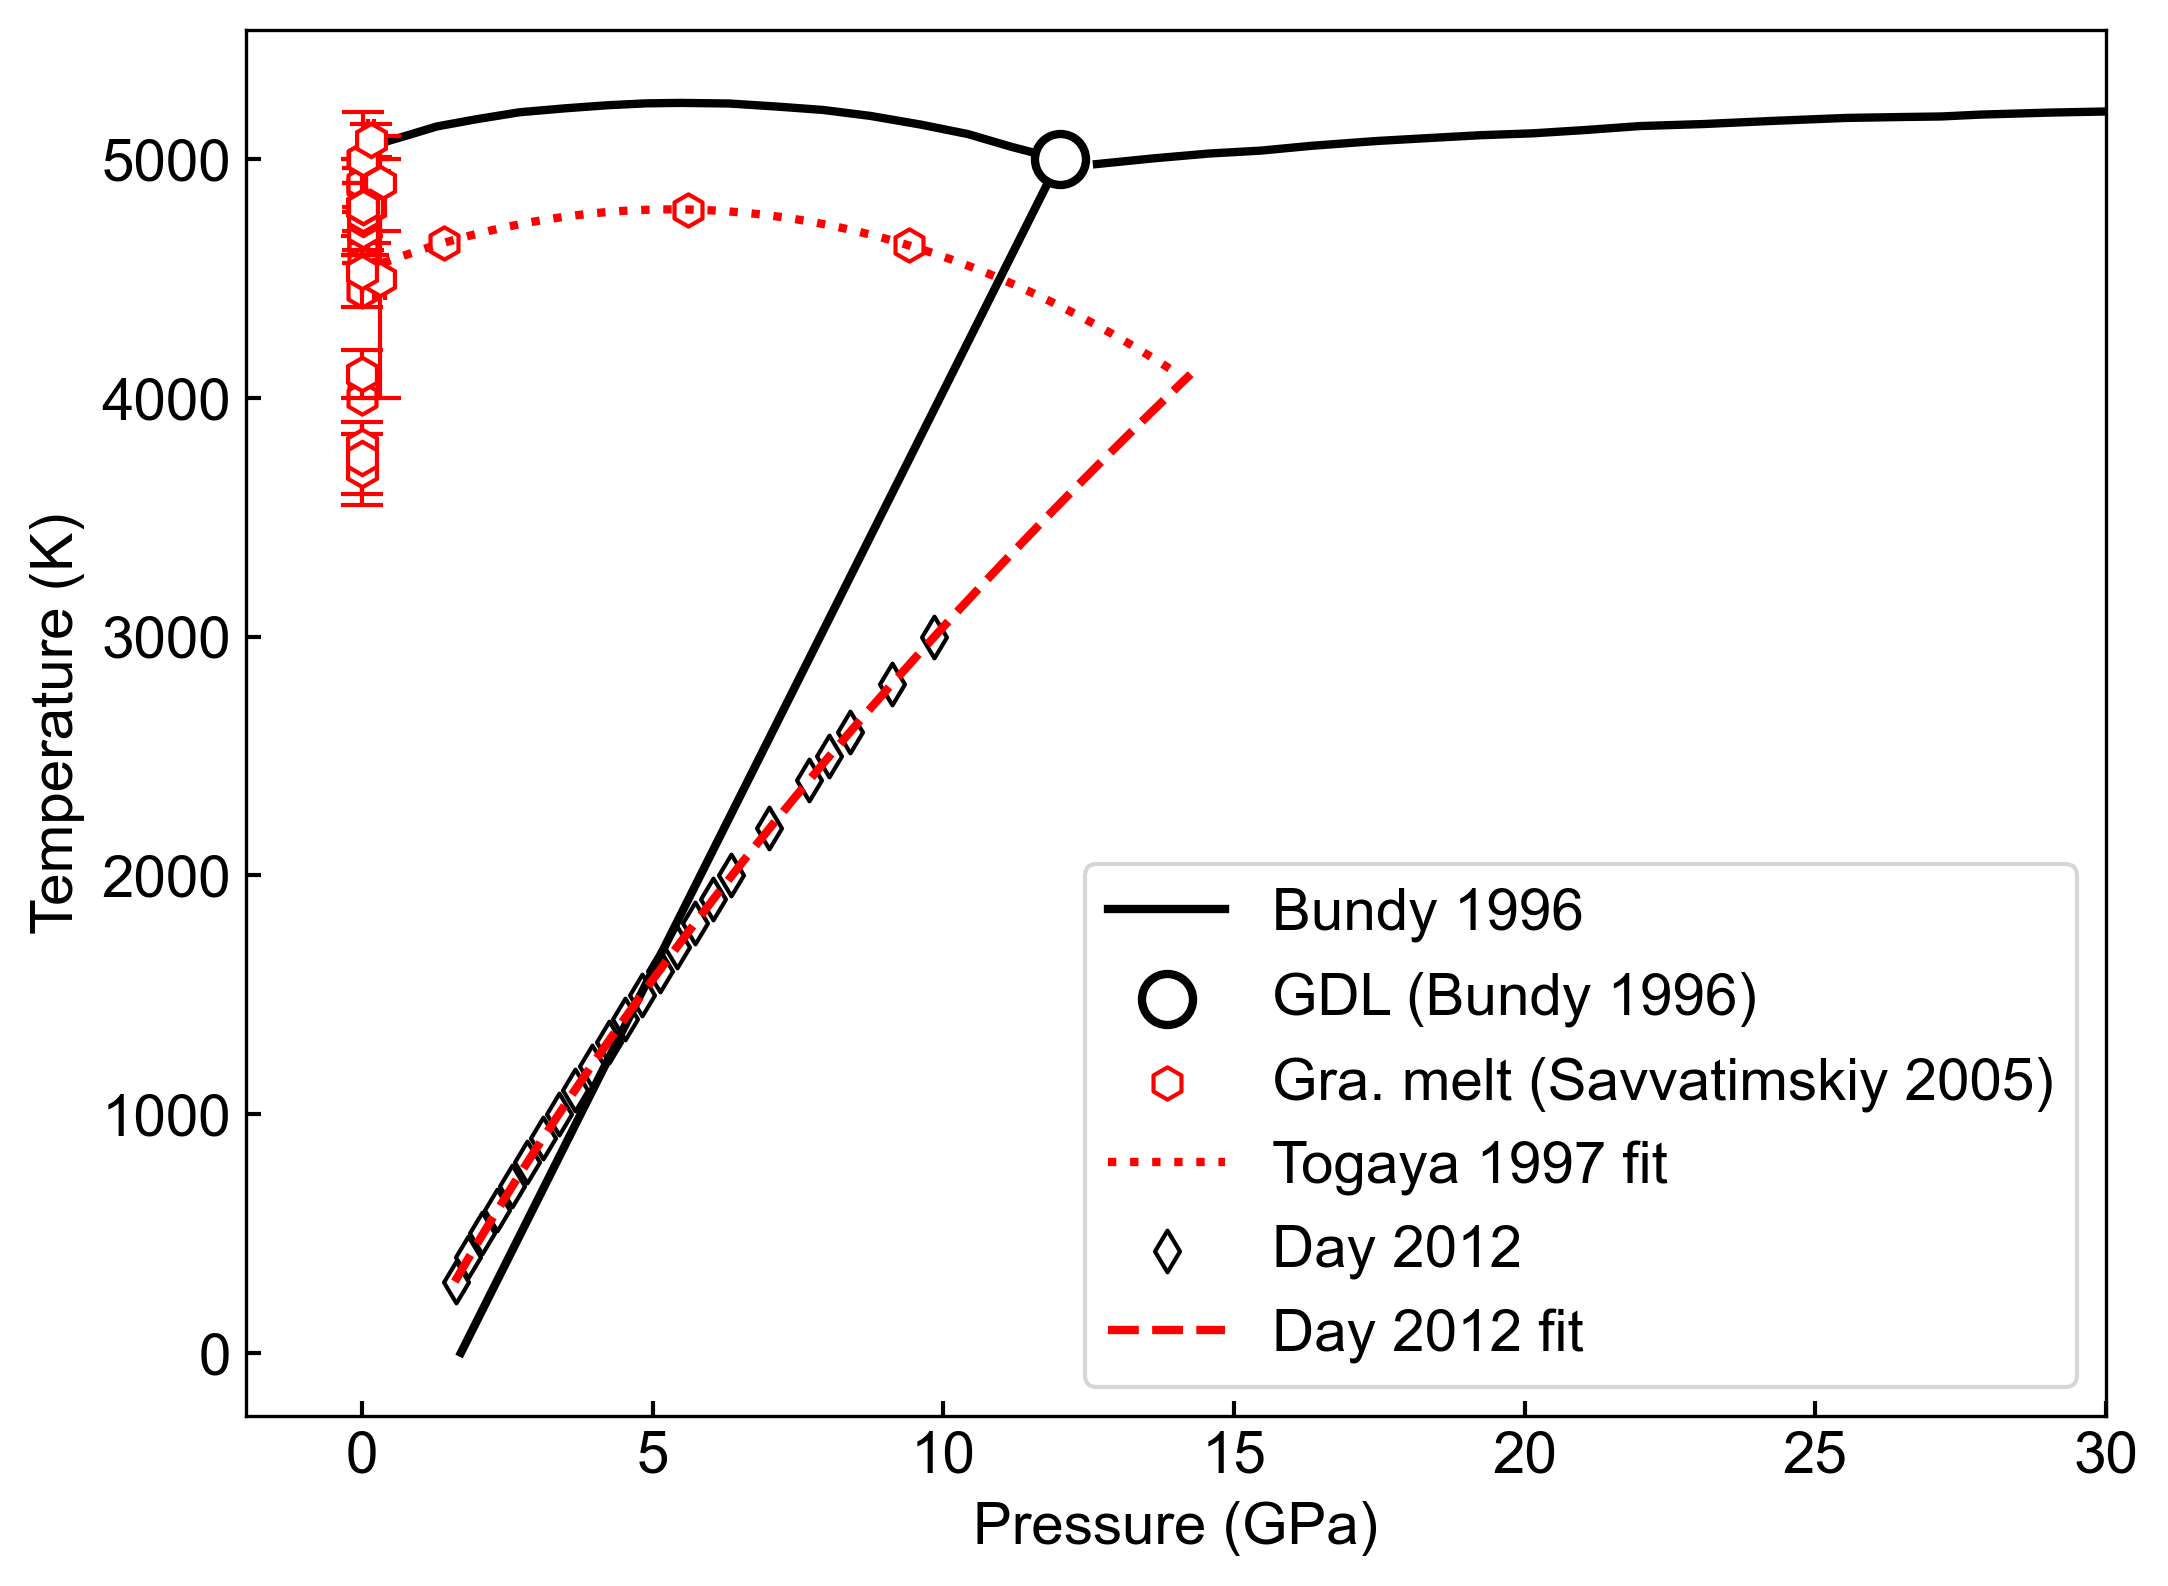

In [293]:
fig, ax = plt.subplots()

plot_bundy_lines(ax=ax, with_DL=True)
plot_GDL(ax=ax)

plot_graphite_melting(ax=ax)
plot_togaya_fit(ax=ax)

plot_day(ax=ax)
plot_day_fit(ax=ax)
add_PT_label(ax=ax)
ax.set_xlim(-2, 30)
plt.legend()

## 1.2TPaまでの炭素相図

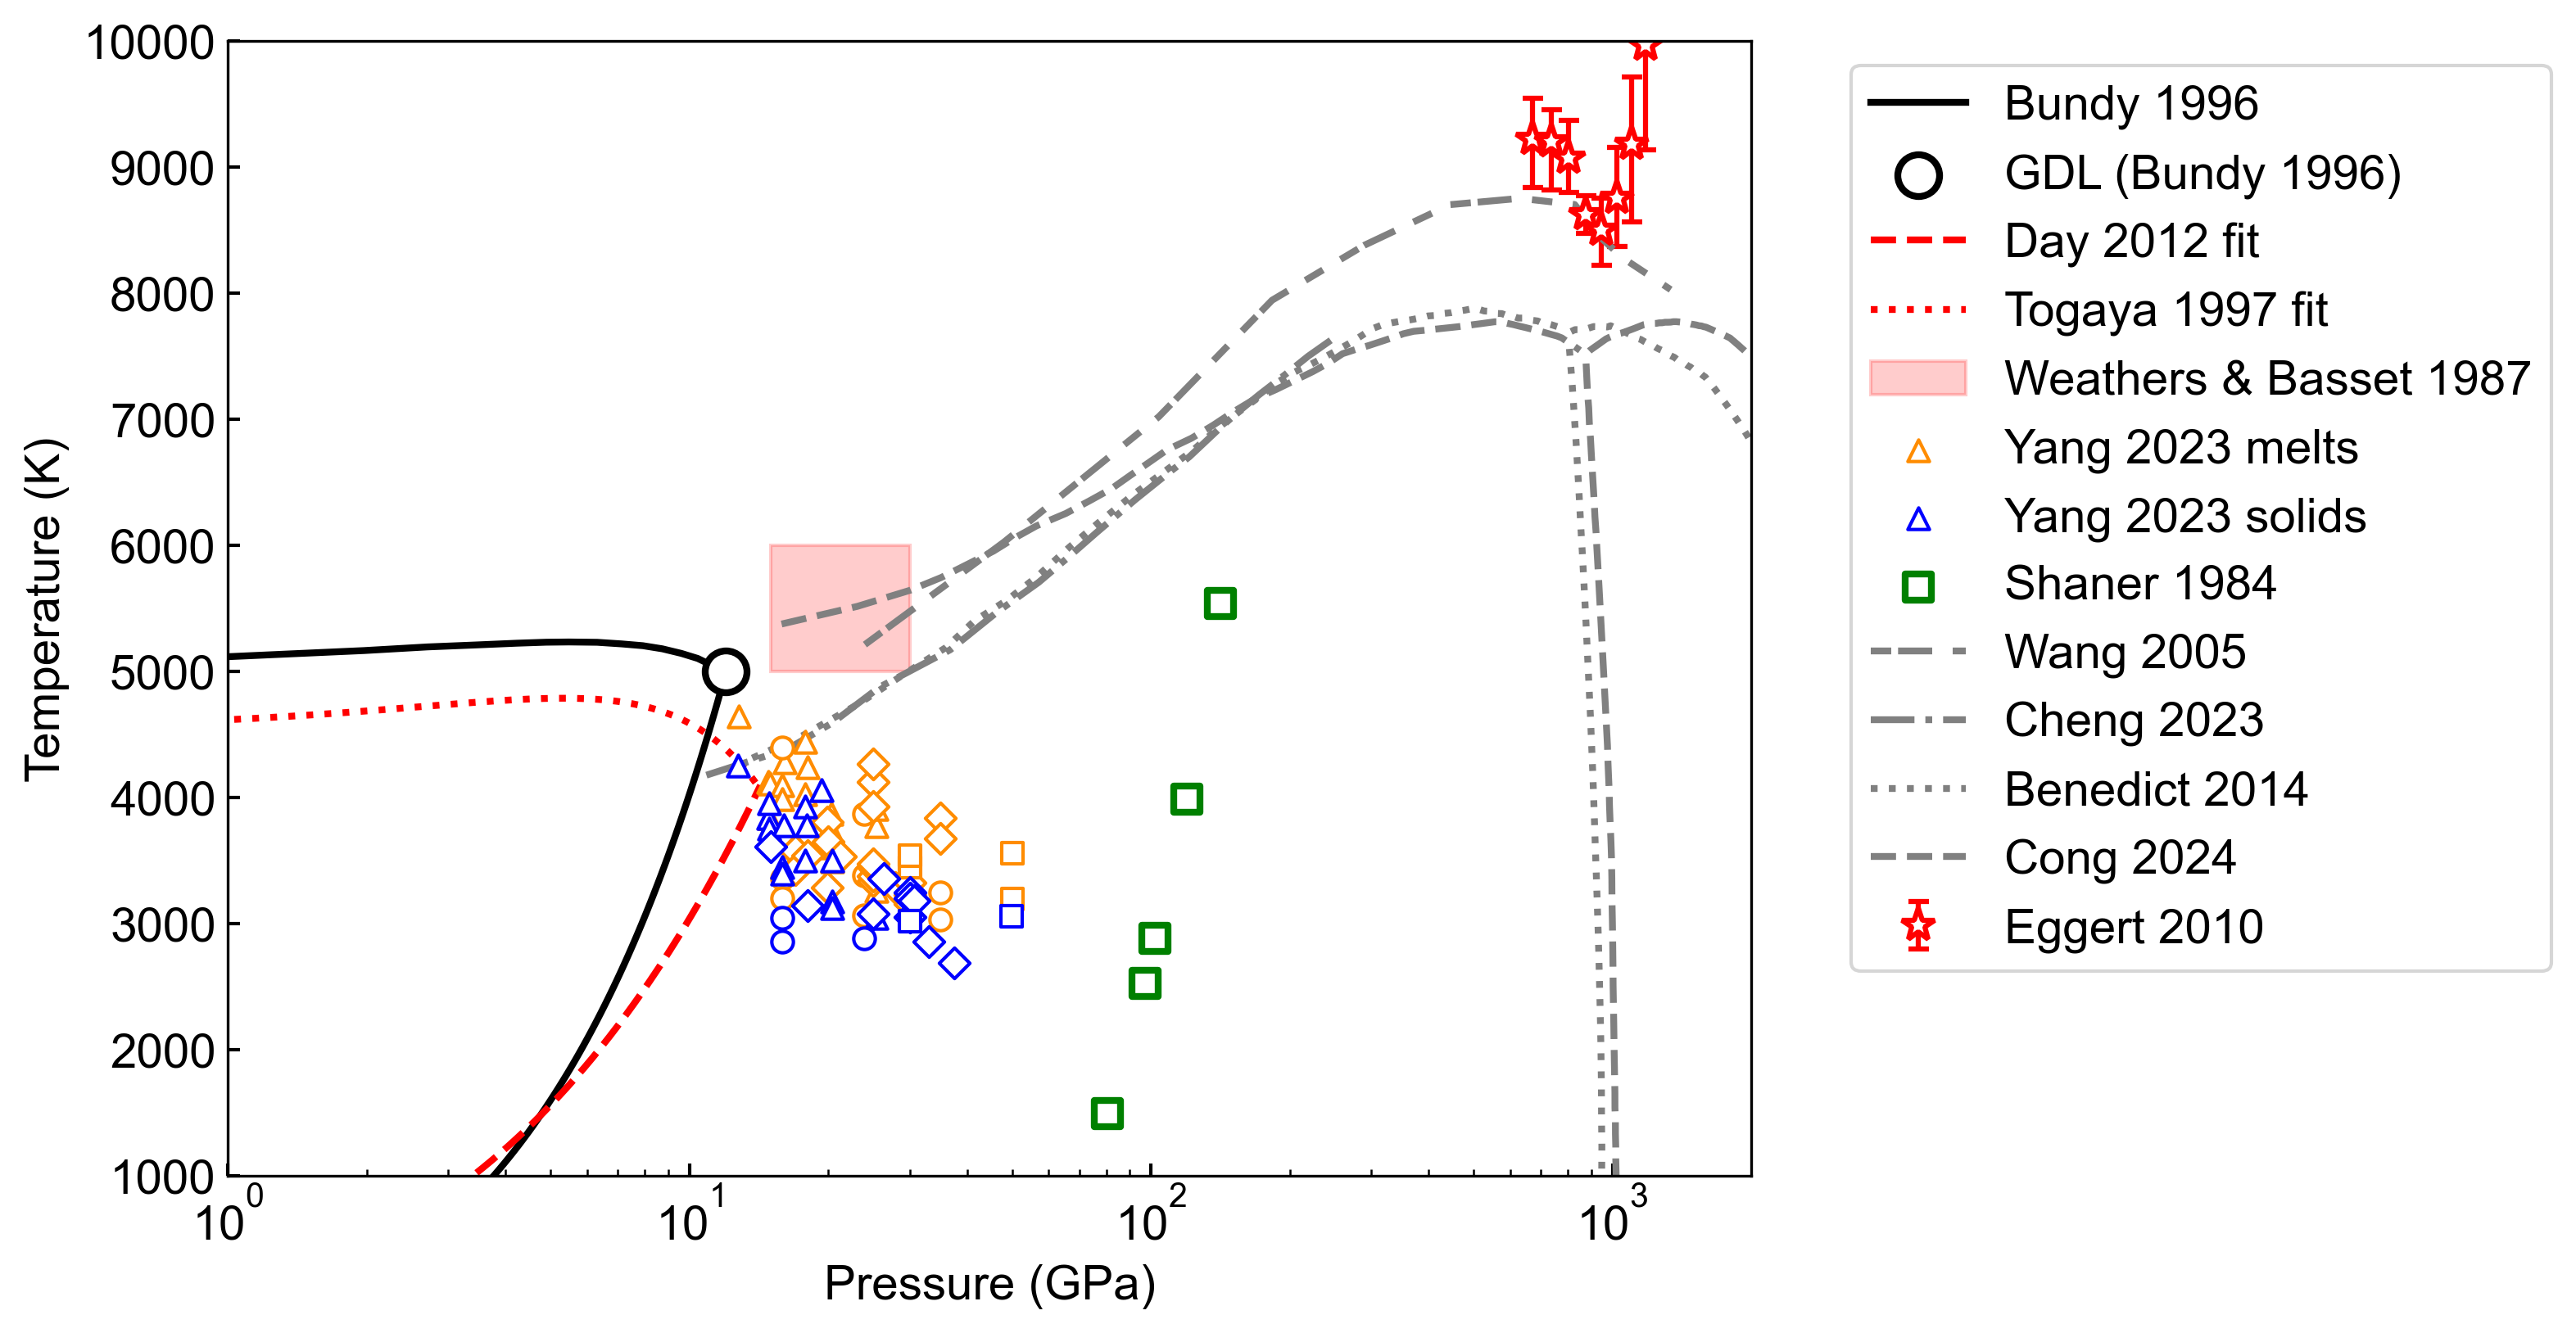

In [294]:
fig, ax = plt.subplots()

plot_bundy_lines(ax=ax)
plot_GDL(ax=ax)
plot_day_fit(ax=ax)
plot_togaya_fit(ax=ax)

# DAC
plot_WB_area(ax=ax)
plot_yang(ax, yang_melts, yang_solids, yang_markers, yang_melt_option, yang_solid_option)

# shock
plot_shaner(ax=ax)
plot_eggert(ax=ax)

# calc
plot_DL_boundaries(ax, DL_boundaries_data)
plot_boundaries(ax, benedict_boundaries, "Benedict 2014", benedict_boundaries_option)
plot_boundaries(ax, cong_boundaries, "Cong 2024", cong_boundaries_option)

# 軸と凡例設定
ax.set_xlim(1, 2_000)
plt.xscale('log')
ax.set_ylim(1_000, 10_000)
add_PT_label(ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


## 1. 地球の図

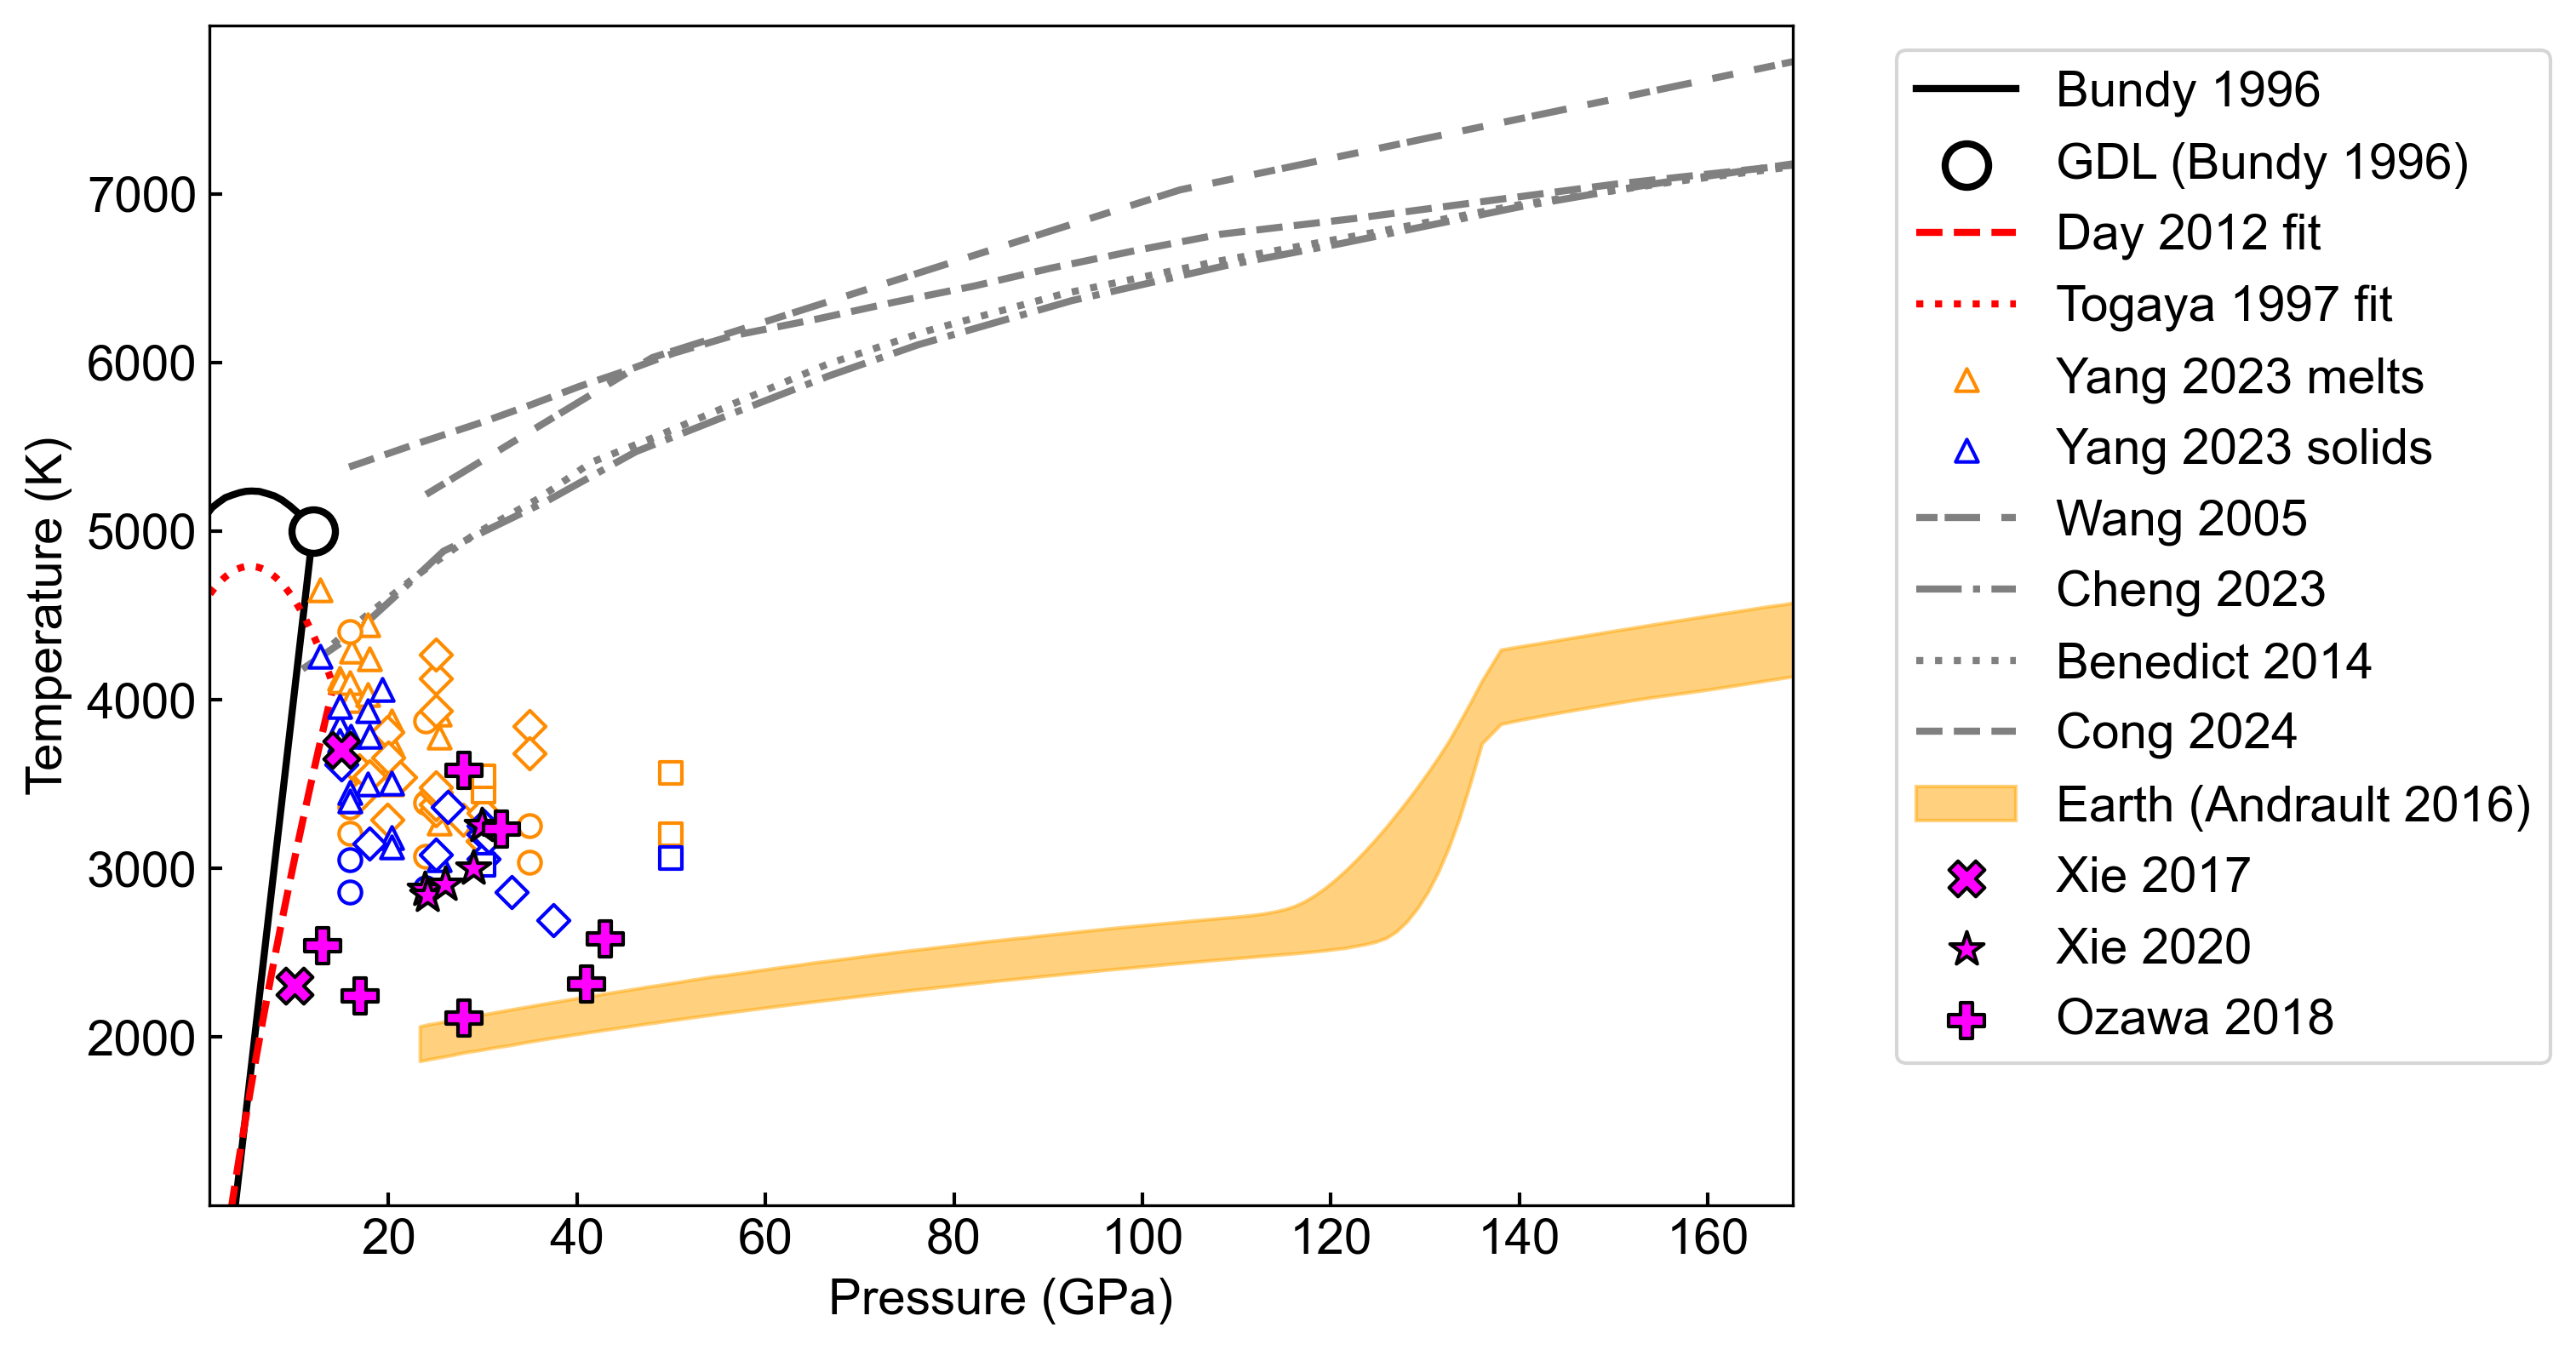

In [295]:
fig, ax = plt.subplots()

plot_bundy_lines(ax=ax)
plot_GDL(ax=ax)
plot_day_fit(ax=ax)
plot_togaya_fit(ax=ax)

# DAC
plot_yang(ax, yang_melts, yang_solids, yang_markers, yang_melt_option, yang_solid_option)

# calc
plot_DL_boundaries(ax, DL_boundaries_data)
plot_boundaries(ax, benedict_boundaries, "Benedict 2014", benedict_boundaries_option)
plot_boundaries(ax, cong_boundaries, "Cong 2024", cong_boundaries_option)

# 地球geotherm
plot_earth_andrault(ax=ax)
plot_heaters(ax=ax)

plt.xlim(1, 169)
plt.ylim(1_001, 7_999)
add_PT_label(ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## 1.氷惑星の図

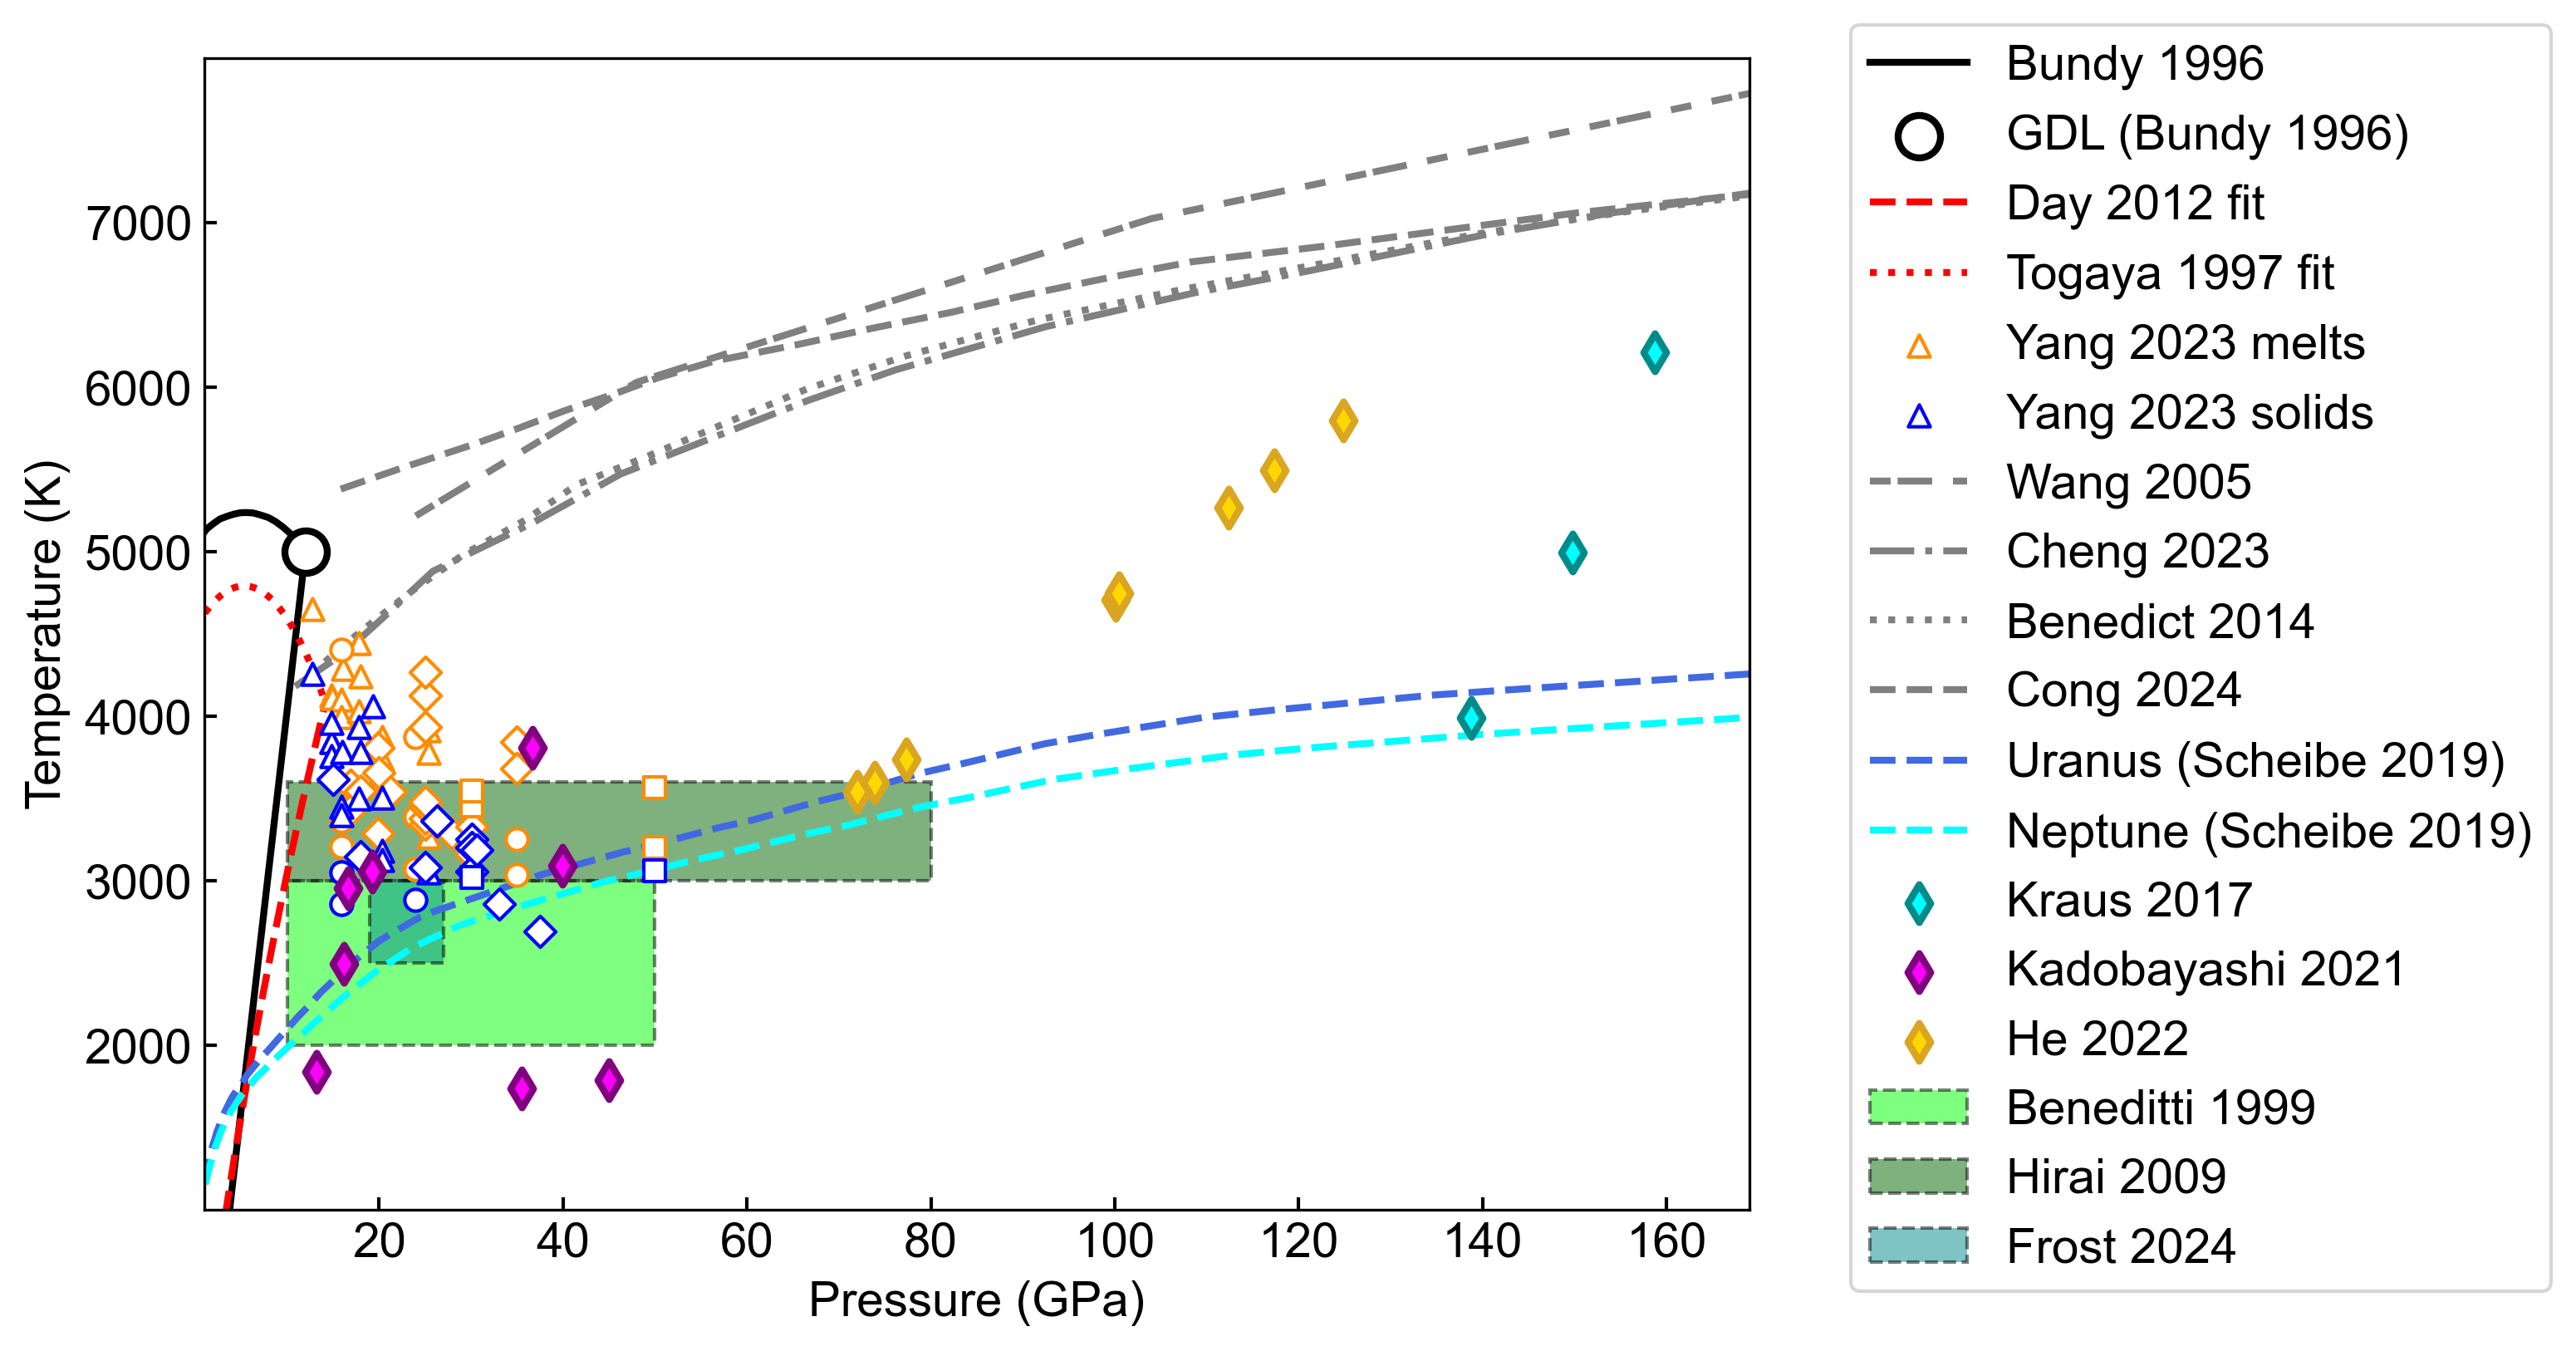

In [296]:
fig, ax = plt.subplots()

plot_bundy_lines(ax=ax)
plot_GDL(ax=ax)
plot_day_fit(ax=ax)
plot_togaya_fit(ax=ax)

# DAC
plot_yang(ax, yang_melts, yang_solids, yang_markers, yang_melt_option, yang_solid_option)

# calc
plot_DL_boundaries(ax, DL_boundaries_data)
plot_boundaries(ax, benedict_boundaries, "Benedict 2014", benedict_boundaries_option)
plot_boundaries(ax, cong_boundaries, "Cong 2024", cong_boundaries_option)

# geotherm
plot_icy_planets(ax=ax)
plot_diamond_conditions(ax=ax)
plot_formation_areas(ax=ax)

plt.xlim(1, 169)
plt.ylim(1_001, 7_999)
add_PT_label(ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))




# Result & Implication

## 3. 炭素相図

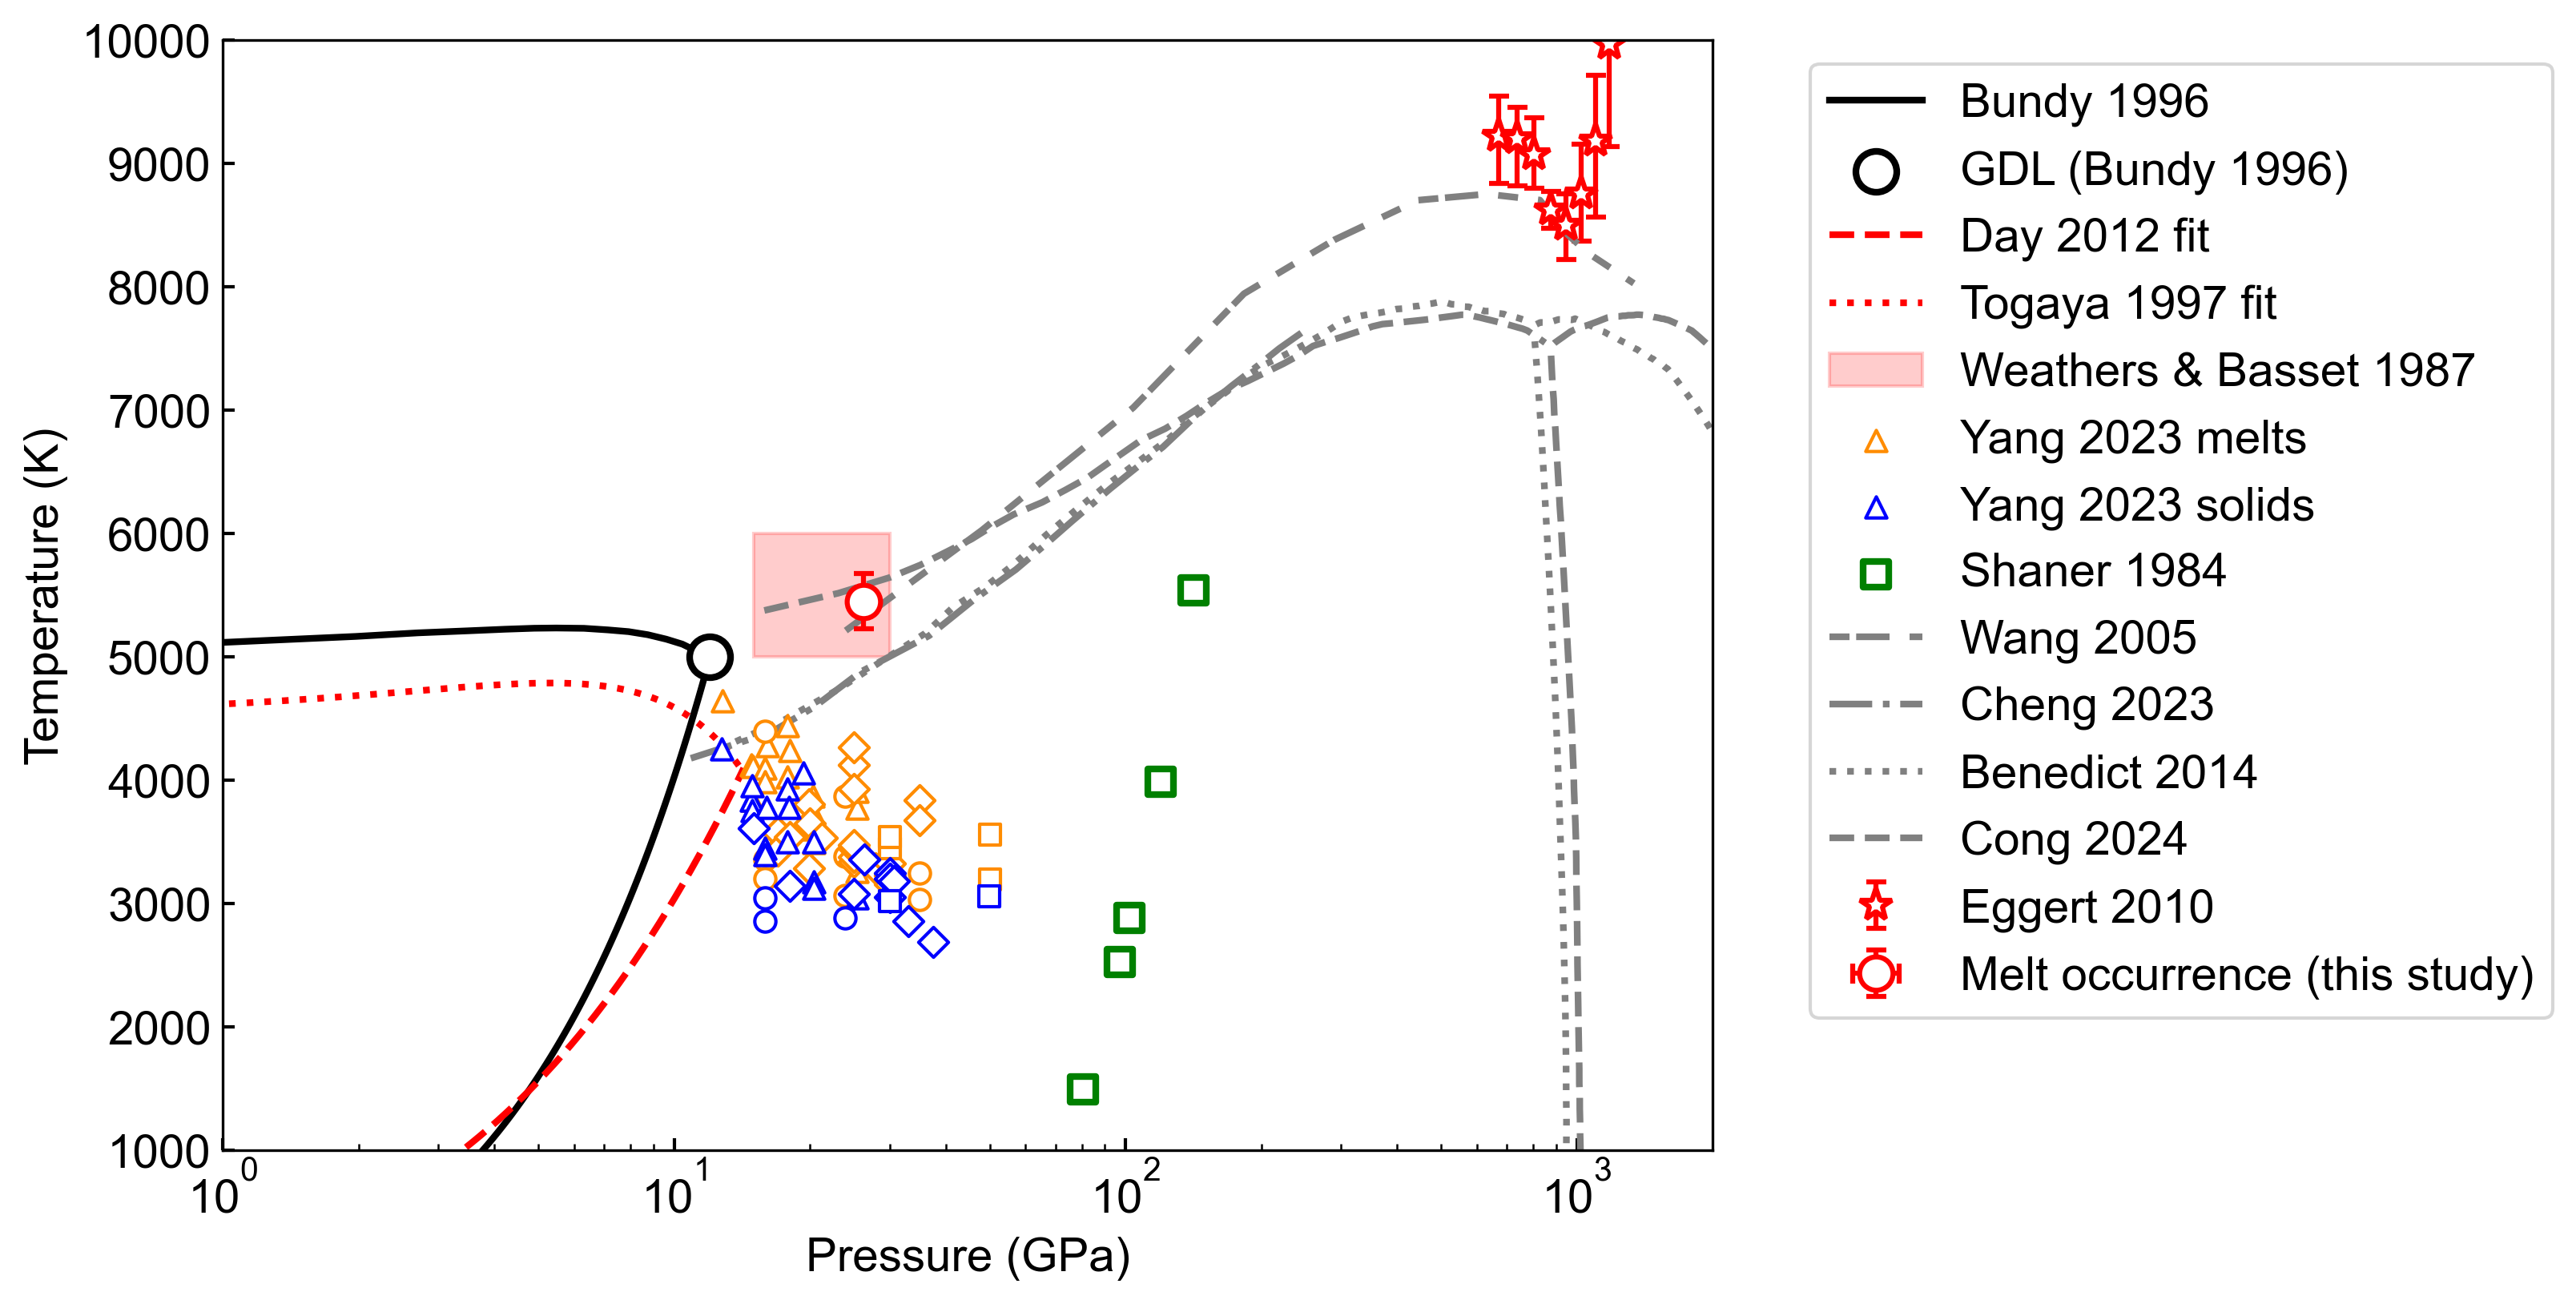

In [297]:
fig, ax = plt.subplots()

plot_bundy_lines(ax=ax)
plot_GDL(ax=ax)
plot_day_fit(ax=ax)
plot_togaya_fit(ax=ax)

# DAC
plot_WB_area(ax=ax)
plot_yang(ax, yang_melts, yang_solids, yang_markers, yang_melt_option, yang_solid_option)

# shock
plot_shaner(ax=ax)
plot_eggert(ax=ax)

# calc
plot_DL_boundaries(ax, DL_boundaries_data)
plot_boundaries(ax, benedict_boundaries, "Benedict 2014", benedict_boundaries_option)
plot_boundaries(ax, cong_boundaries, "Cong 2024", cong_boundaries_option)

# result
plot_results(ax=ax)

# 軸と凡例設定
ax.set_xlim(1, 2_000)
plt.xscale('log')
ax.set_ylim(1_000, 10_000)
add_PT_label(ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))



## 4.地球

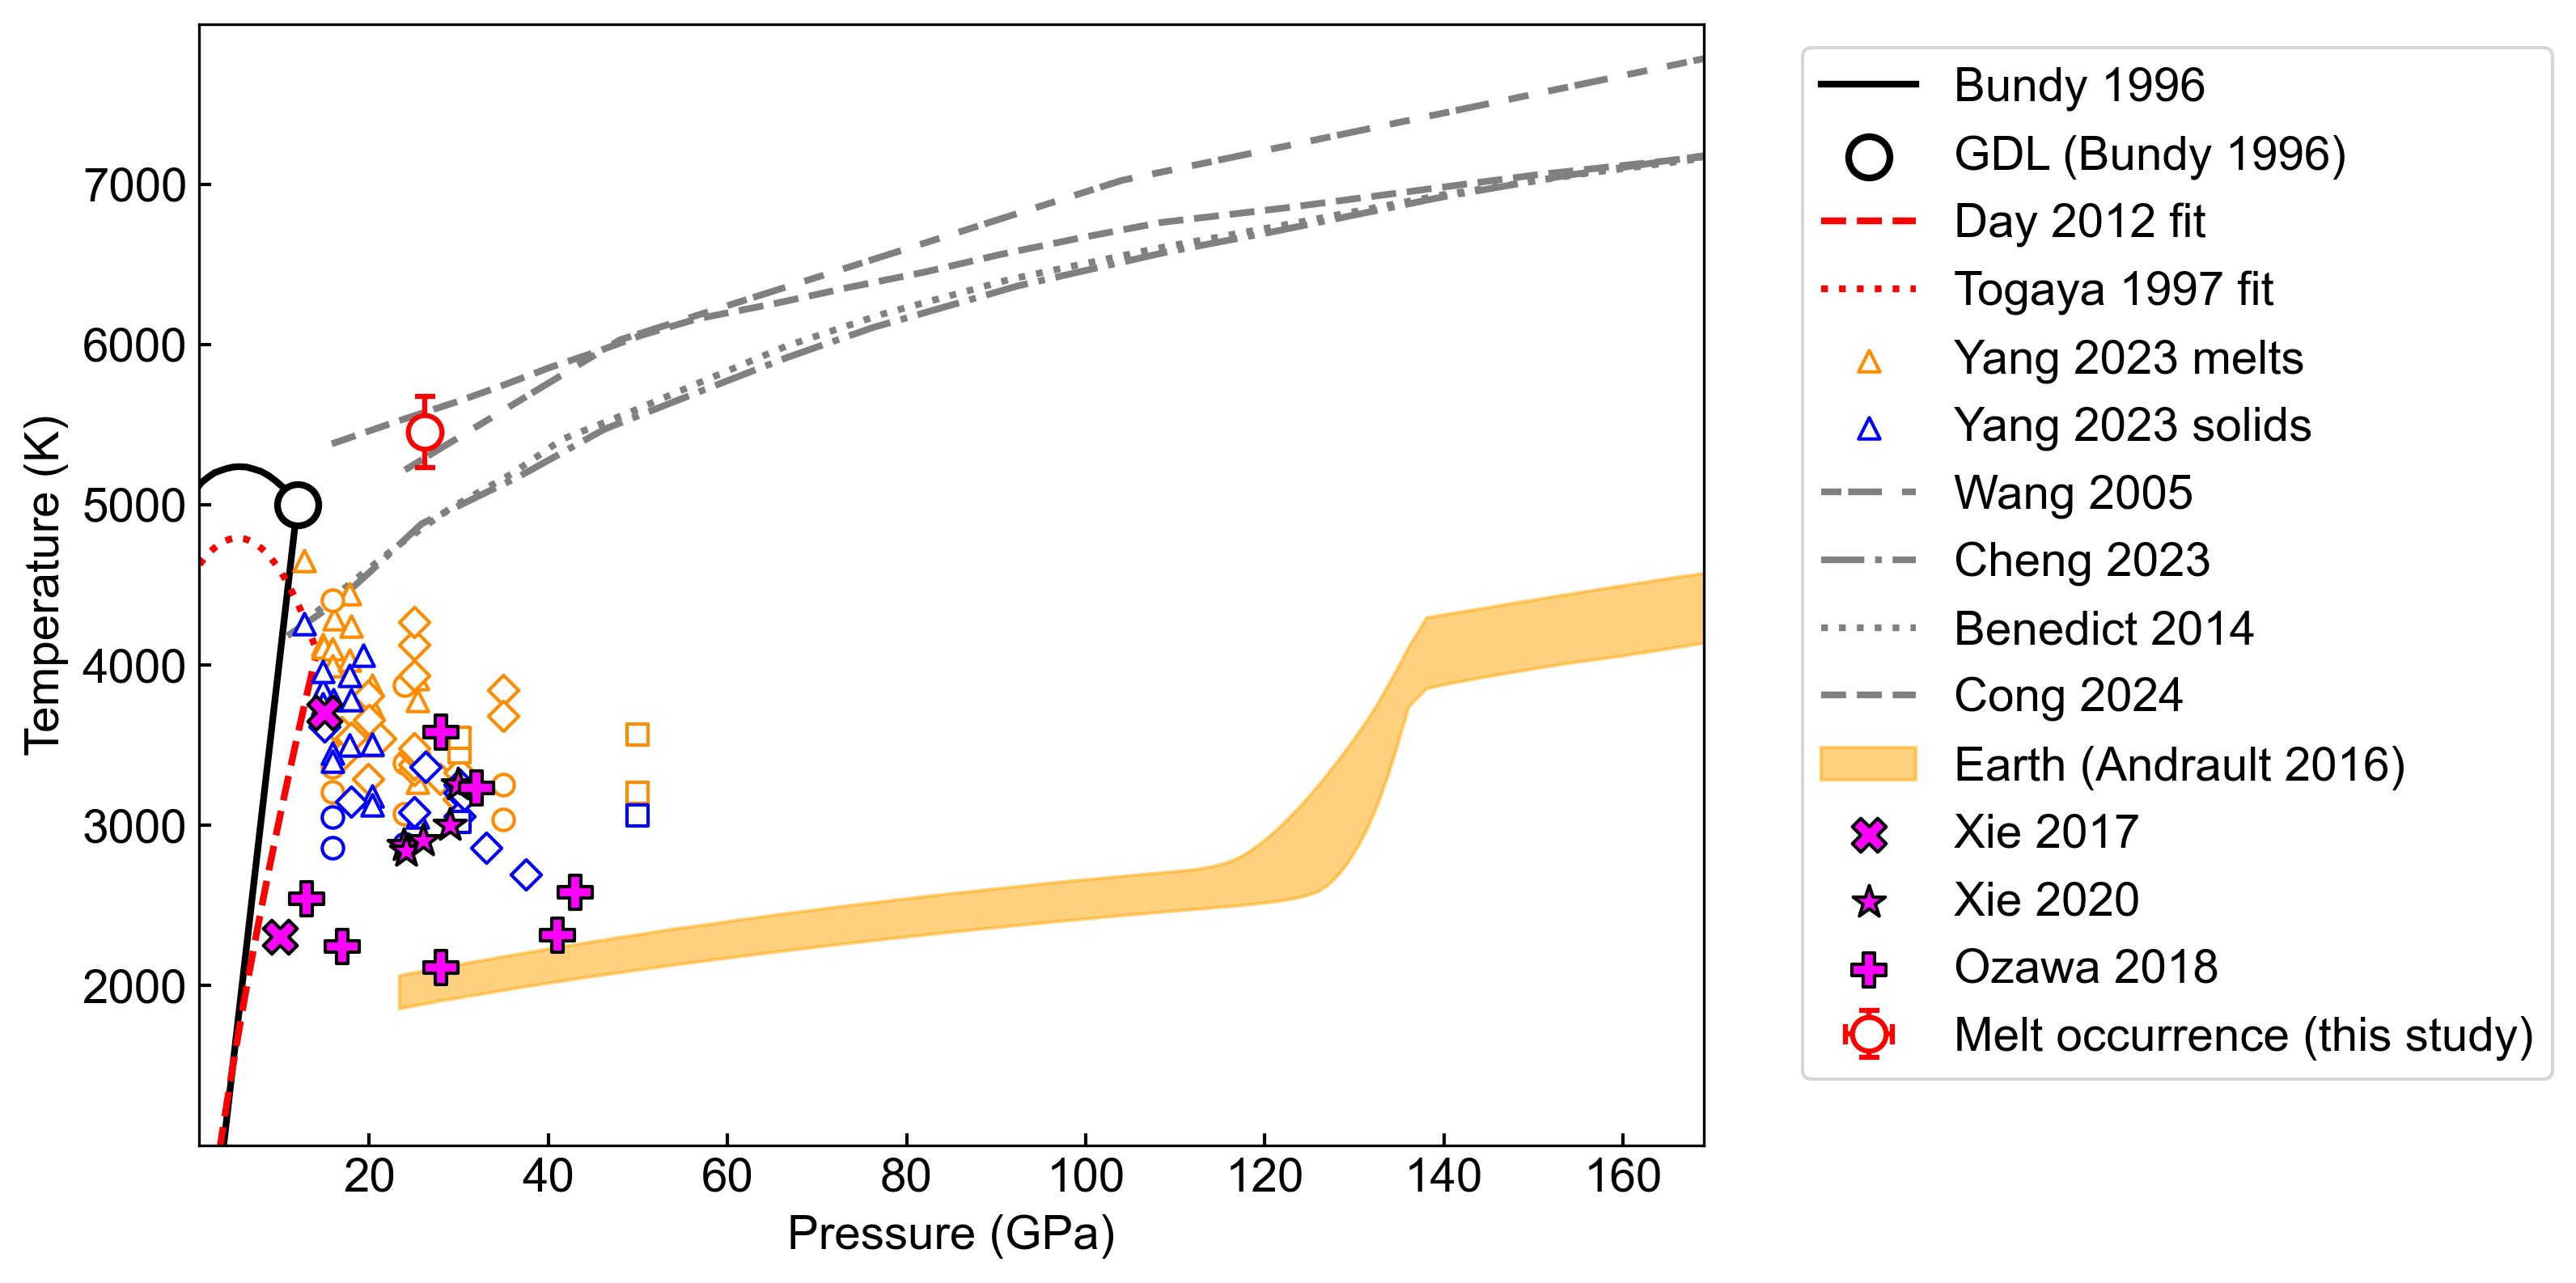

In [298]:
fig, ax = plt.subplots()

plot_bundy_lines(ax=ax)
plot_GDL(ax=ax)
plot_day_fit(ax=ax)
plot_togaya_fit(ax=ax)

# DAC
plot_yang(ax, yang_melts, yang_solids, yang_markers, yang_melt_option, yang_solid_option)

# calc
plot_DL_boundaries(ax, DL_boundaries_data)
plot_boundaries(ax, benedict_boundaries, "Benedict 2014", benedict_boundaries_option)
plot_boundaries(ax, cong_boundaries, "Cong 2024", cong_boundaries_option)

# 地球geotherm
plot_earth_andrault(ax=ax)
plot_heaters(ax=ax)

plot_results(ax=ax)

plt.xlim(1, 169)
plt.ylim(1_001, 7_999)
add_PT_label(ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


## 4. 氷惑星

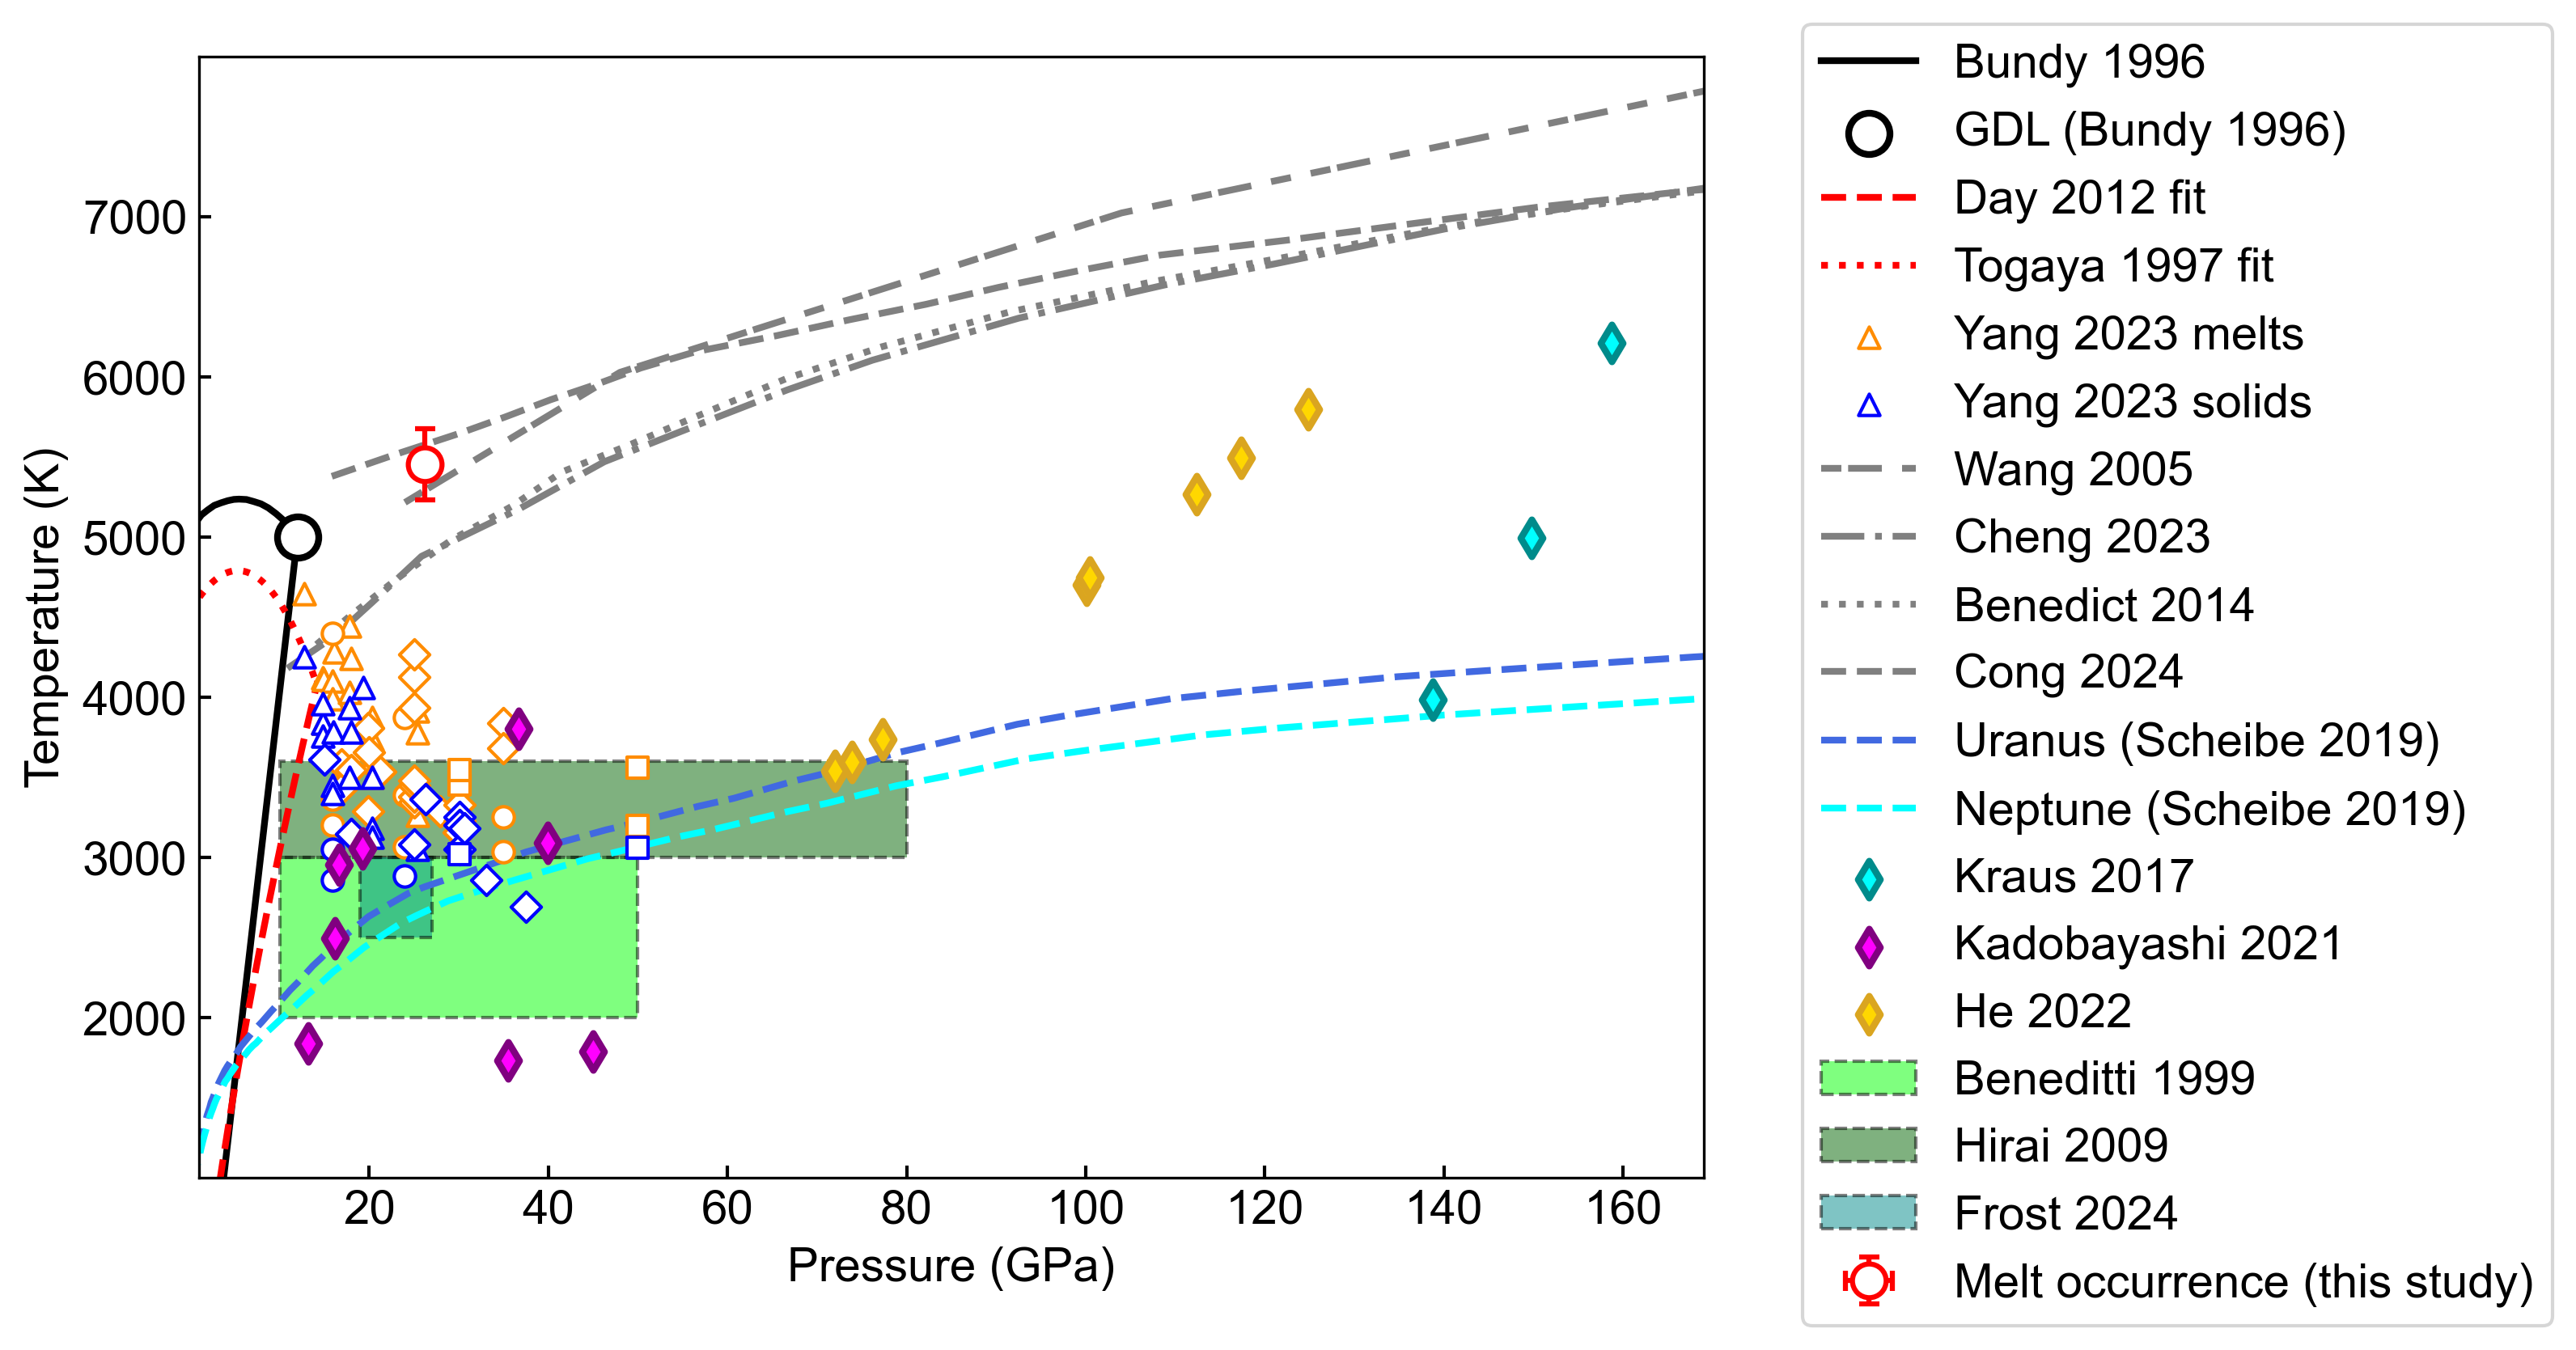

In [299]:
fig, ax = plt.subplots()

plot_bundy_lines(ax=ax)
plot_GDL(ax=ax)
plot_day_fit(ax=ax)
plot_togaya_fit(ax=ax)

# DAC
plot_yang(ax, yang_melts, yang_solids, yang_markers, yang_melt_option, yang_solid_option)

# calc
plot_DL_boundaries(ax, DL_boundaries_data)
plot_boundaries(ax, benedict_boundaries, "Benedict 2014", benedict_boundaries_option)
plot_boundaries(ax, cong_boundaries, "Cong 2024", cong_boundaries_option)

# geotherm
plot_icy_planets(ax=ax)
plot_diamond_conditions(ax=ax)
plot_formation_areas(ax=ax)

plot_results(ax=ax)

plt.xlim(1, 169)
plt.ylim(1_001, 7_999)
add_PT_label(ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))

